In [1]:
!pip install spotipy
import spotipy

In [2]:
username = '12122472697'

In [3]:
import sys
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
CLIENT_ID = '9e56856c12474c608836e0f90f1dfa6b'
CLIENT_SECRET = '5a82ddfd2828423aa5781c8f091e0847'

In [6]:
client_credentials_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
spotify = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
sp = spotify

Exmample without user authen

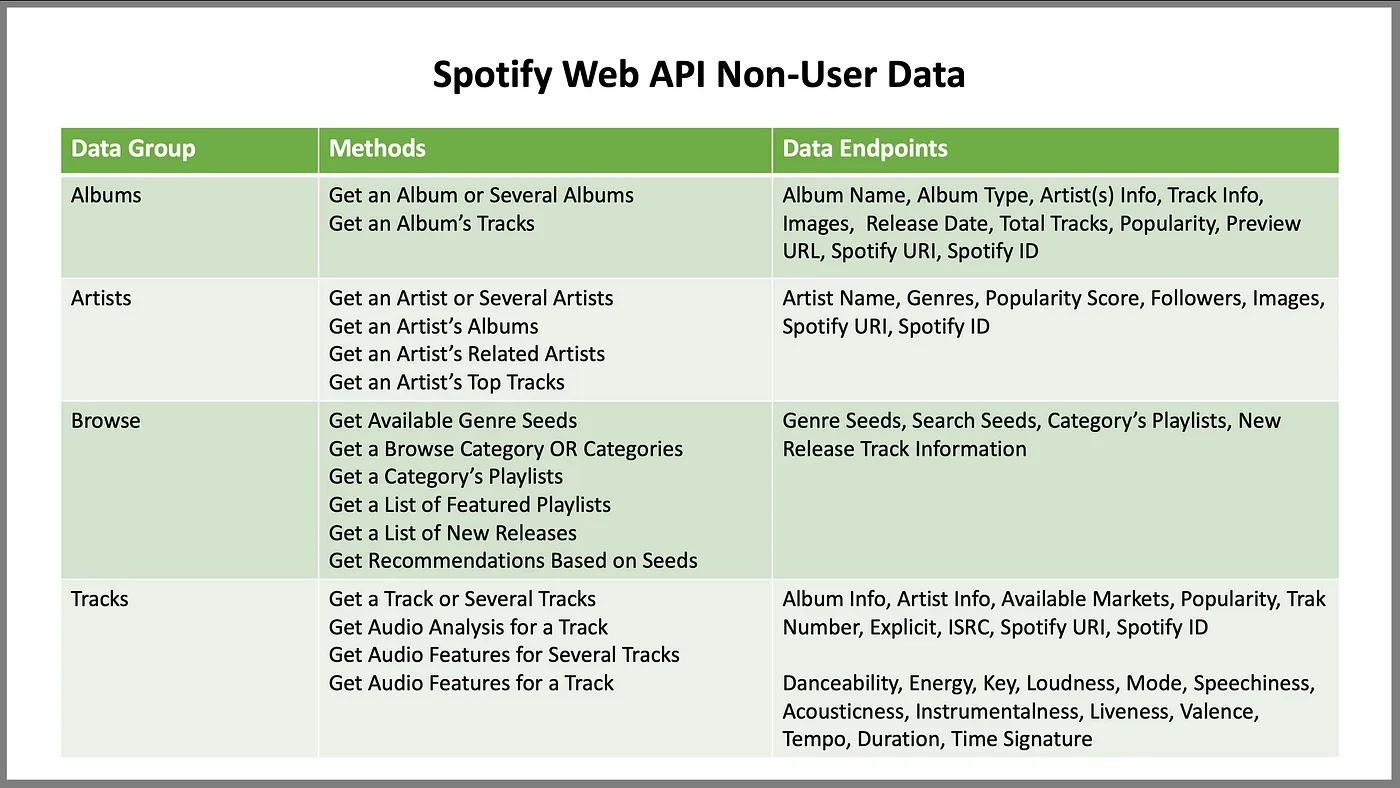

In [7]:
results = sp.search(q='Sheer Mag', limit=2)
for idx, track in enumerate(results['tracks']['items']):
    print(idx, track['name'])

0 Silver Line
1 All Lined Up


### Load in personal spotify history

In [1]:
df22 = pd.read_json('Streaming_History_Audio_2020-2021_22.json')

df25 = pd.read_json('Streaming_History_Audio_2021-2022_25.json')

df28 = pd.read_json('Streaming_History_Audio_2022-2023_28.json')

df30 = pd.read_json('Streaming_History_Audio_2023-2024_30.json')


NameError: name 'pd' is not defined

In [187]:
dfs = [df25, df28, df30]
merged = df22

In [188]:
for df in dfs:
  merged = pd.merge(merged, df, how='outer')

C:\Users\AJ\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:916: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  key_col = Index(lvals).where(~mask_left, rvals)


In [189]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61103 entries, 0 to 61102
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   ts                                 61103 non-null  object
 1   username                           61103 non-null  int64 
 2   platform                           61103 non-null  object
 3   ms_played                          61103 non-null  int64 
 4   conn_country                       61103 non-null  object
 5   ip_addr_decrypted                  61103 non-null  object
 6   user_agent_decrypted               58172 non-null  object
 7   master_metadata_track_name         59647 non-null  object
 8   master_metadata_album_artist_name  59647 non-null  object
 9   master_metadata_album_album_name   59647 non-null  object
 10  spotify_track_uri                  59647 non-null  object
 11  episode_name                       1449 non-null   object
 12  epis

In [24]:
merged.tail(1)

,ts,username,platform,ms_played,conn_country,ip_addr_decrypted,user_agent_decrypted,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,...,episode_name,episode_show_name,spotify_episode_uri,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode
61102,2024-01-01T18:41:30Z,12122472697,cast,213401,GB,2a02:c7c:f20c:4200:48a2:2ad7:1347:d62c,Mozilla/5.0 (X11; Linux armv7l) AppleWebKit/53...,Saudade Vem Correndo,Stan Getz,Jazz Samba Encore!,...,None,None,None,remote,trackdone,False,False,False,1704134276,False


In [190]:
# column selection
### create df
df = merged[['ts', 'ms_played', 'master_metadata_track_name', 'master_metadata_album_artist_name',
             'master_metadata_album_album_name', 'spotify_track_uri', 'reason_start',
             'reason_end', 'shuffle', 'skipped']]

In [191]:
# strip the spotofy track uri to get track id
df['spotify_track_uri'] = df['spotify_track_uri'].str.strip('spotify:track:')

C:\Users\AJ\AppData\Local\Temp\ipykernel_25388\2841784152.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['spotify_track_uri'] = df['spotify_track_uri'].str.strip('spotify:track:')


In [192]:
# rename cols
df = df.rename(columns = {'master_metadata_track_name':'track_name',
                          'master_metadata_album_artist_name':'artist_name',
                          'master_metadata_album_album_name':'album_name',
                          'spotify_track_uri':'track_id'})

### Back to spotify API
I'm going to start by focusing on my running playlist because I use it so much. Maybe later I'll try my 2024n fresh finds playlist to find new songs to listen to. I can also do this to create a new playlist for Emily and I to listen to. 


In [8]:
def call_playlist(creator, playlist_id):
    # List to store track features
    playlist_features_list = ['artist', 'album', 'track_name',
                              'track_id', 'duration_ms', 
                              'acousticness', 'danceability',
                              'energy', 'instrumentalness', 'key',
                              'liveness','loudness', 'mode', 'speechiness',
                              'tempo','valence', 'time_signature']
    
    # Initialize an empty DataFrame
    playlist_df = pd.DataFrame(columns=playlist_features_list)
    
    # Retrieve the first batch of tracks
    playlist_response = sp.user_playlist_tracks(creator, playlist_id, limit=100)
    playlist = playlist_response['items']
    
    # Iterate through all batches of tracks
    while playlist:
        for track in playlist:
            # Create empty dictionary to store track features
            playlist_features = {}
            # Extract metadata
            playlist_features['artist'] = track['track']['album']['artists'][0]['name']
            playlist_features['album'] = track['track']['album']['name']
            playlist_features['track_name'] = track['track']['name']
            playlist_features['track_id'] = track['track']['id']
            
            # Get the audio features
            audio_features = sp.audio_features(playlist_features['track_id'])[0]
            
            # Add audio features to the dictionary
            for feature in playlist_features_list[4:]:
                playlist_features[feature] = audio_features[feature]
            
            # Convert dictionary to DataFrame and append to playlist_df
            track_df = pd.DataFrame(playlist_features, index=[0])
            playlist_df = pd.concat([playlist_df, track_df], ignore_index=True)
        
        # Check if there are more tracks to retrieve
        playlist_response = sp.next(playlist_response)
        if playlist_response:
            playlist = playlist_response['items']
        else:
            # If there are no more tracks, exit the loop
            break
    
    # Return the DataFrame containing all track features
    return playlist_df

In [15]:
# running playlist 66SQQ94SLwJC6f7uzAkV6i
# sleeping on public transit: 0aRAWHGG6BQhqcuevk910m
running_playlist = call_playlist('spotify', '66SQQ94SLwJC6f7uzAkV6i')

In [11]:
running_playlist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   artist            148 non-null    object
 1   album             148 non-null    object
 2   track_name        148 non-null    object
 3   track_id          148 non-null    object
 4   duration_ms       148 non-null    object
 5   acousticness      148 non-null    object
 6   danceability      148 non-null    object
 7   energy            148 non-null    object
 8   instrumentalness  148 non-null    object
 9   key               148 non-null    object
 10  liveness          148 non-null    object
 11  loudness          148 non-null    object
 12  mode              148 non-null    object
 13  speechiness       148 non-null    object
 14  tempo             148 non-null    object
 15  valence           148 non-null    object
 16  time_signature    148 non-null    object
dtypes: object(17)
me

Spotify generates specific playlists for its users. I've used the High Energy Workout before for lifting so I'm going to use it to help with creating a recommender for my new running laylist. ID:37i9dQZF1EIeLflS1D0w73

#### Analyze Multiple Playlists

In [16]:
   # "sleeping_on_public_transit" : ('spotify', '0aRAWHGG6BQhqcuevk910m'),
   # "high_energy_workout" : ('spotify', '37i9dQZF1EIeLflS1D0w73'),
    #"2024_freshish_find" : ('spotify', '6Fe170LMj4OtV7jqQLXjmi'),
   # "acid_westerns" : ('spotify', '4f68cH00vGq3yzjb6E3sMY')
    


In [9]:
acid_westerns = call_playlist('spotify', '4f68cH00vGq3yzjb6E3sMY')

In [18]:
acid_westerns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   artist            268 non-null    object
 1   album             268 non-null    object
 2   track_name        268 non-null    object
 3   track_id          268 non-null    object
 4   duration_ms       268 non-null    object
 5   acousticness      268 non-null    object
 6   danceability      268 non-null    object
 7   energy            268 non-null    object
 8   instrumentalness  268 non-null    object
 9   key               268 non-null    object
 10  liveness          268 non-null    object
 11  loudness          268 non-null    object
 12  mode              268 non-null    object
 13  speechiness       268 non-null    object
 14  tempo             268 non-null    object
 15  valence           268 non-null    object
 16  time_signature    268 non-null    object
dtypes: object(17)
me

In [10]:
# function to get genres out the artists.
# Define a function to get genre for an artist
def get_artist_genre(artist_name):
    # Search for the artist
    result = sp.search(q='artist:' + artist_name, type='artist', limit=1)
    # Extract genre if artist found
    if result['artists']['items']:
        genres = result['artists']['items'][0]['genres']
        if genres:
            return genres[0]  # Return the first genre if available
    return None  # Return None if no genre found

In [ ]:
# try adding 'spotify:track:' to the beginnging of track id
acid_westerns['genre'] = acid_westerns['artist'].apply(lambda x: get_artist_genre(x))
acid_westerns.head()

In [89]:
# function to get popularity ratings 
def get_track_popularity(track_id):
    # Retrieve track information
    track_info = sp.track(track_id)
    # Extract popularity if track found
    if track_info:
        popularity = track_info['popularity']
        return popularity
    return None  # Return None if track not found

In [90]:
acid_westerns['popularity'] = acid_westerns['track_id'].apply(lambda x: get_artist_genre(x))

In [93]:
acid_westerns.sample(5)

,artist,album,track_name,track_id,duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,time_signature,genre,popularity
126,Federale,All the Colours of the Dark,The Fire Came Down from the Mountain,spotify:track:2WK2l7ewNHzovliBzLb6s8,296330,0.292,0.421,0.754,0.229,11,0.368,-3.98,0,0.0327,129.011,0.476,4,musica neoleonesa,None
223,The Gun Club,Miami,Mother of Earth,spotify:track:42By3JR99fe6fkHHVBHyhH,204640,0.247,0.288,0.843,0.375,2,0.223,-4.876,1,0.0565,183.946,0.685,4,cowpunk,None
2,A. Savage,The Loft Sessions,I Can't Shake the Stranger Out of You,spotify:track:5dJskdUj4OoHI2nTosbTvU,239400,0.308,0.442,0.507,0.000251,9,0.294,-6.431,1,0.028,137.778,0.58,4,garage psych,None
141,Willie Griffin,I Love You,Where There's Smoke There's Fire,spotify:track:6ZdbPU9At1M2bFmFaJJc26,206037,0.0376,0.549,0.512,0.000028,6,0.118,-12.032,0,0.047,158.989,0.449,4,None,None
47,Parquet Courts,Light Up Gold + Tally All The Things That You ...,N Dakota,spotify:track:6bF5mUzL2xdZO5Y28orRLx,139333,0.459,0.658,0.56,0.0188,5,0.113,-9.88,1,0.031,115.079,0.458,4,alternative rock,None


In [21]:
acid_westerns['genre'] = acid_westerns['artist'].apply(lambda x: get_artist_genre(x))
acid_westerns.head()

,artist,album,track_name,track_id,duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,time_signature,genre
0,Quadro Nuevo,Mocca Flor,Miserlou,0YelOFho2AL8r0gcsHB5f6,285240,0.658,0.43,0.483,0.875,2,0.107,-9.206,1,0.0325,87.698,0.213,3,tango
1,Dos Santos,City of Mirrors,Alma Cósmica,2F87QGXh2d4GfWyk6AlVS4,126787,0.0035,0.576,0.797,0.000911,11,0.094,-8.082,0,0.0775,173.861,0.786,4,None
2,A. Savage,The Loft Sessions,I Can't Shake the Stranger Out of You,5dJskdUj4OoHI2nTosbTvU,239400,0.308,0.442,0.507,0.000251,9,0.294,-6.431,1,0.028,137.778,0.58,4,garage psych
3,The Blue Angel Lounge,The Blue Angel Lounge,LSD and the Search for God,7aqn0YEOwcpSjIzakWSXdx,247355,0.0502,0.324,0.793,0.854,9,0.332,-3.752,1,0.0363,120.366,0.387,4,german shoegaze
4,Hermanos Gutiérrez,Tres Hermanos,Tres Hermanos,0cb9Ov9eC2eFxac6bCcUZl,201413,0.974,0.631,0.459,0.934,0,0.146,-9.933,0,0.0349,94.604,0.542,4,None


In [22]:
running_playlist['genre'] = running_playlist['artist'].apply(lambda x: get_artist_genre(x))
running_playlist.head()

,artist,album,track_name,track_id,duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,time_signature,genre
0,Parquet Courts,Light Up Gold,Stoned And Starving,6CSAKVMzk60vOfG0MJMC6v,311680,0.274,0.236,0.882,0.875,5,0.131,-7.426,1,0.0586,169.735,0.29,4,alternative rock
1,LCD Soundsystem,45:33,45:33,4jfJb4I62fGIRrhbClYcHG,2764934,0.138,0.478,0.897,0.657,7,0.1,-6.554,1,0.0471,113.018,0.186,4,alternative dance
2,"Black Country, New Road",Sunglasses,Sunglasses,65UwL8cFTFyMA8uh1nr95p,533739,0.173,0.476,0.499,0.000019,6,0.129,-6.66,0,0.0746,117.013,0.197,4,crank wave
3,Cate Le Bon,Crab Day,What's Not Mine,3BZ17mVqFNdmwVANwAemVj,446627,0.492,0.732,0.378,0.193,0,0.0686,-6.679,1,0.0502,89.446,0.964,4,art pop
4,Nap Eyes,Thought Rock Fish Scale,Stargazer,3rvwOMySfAueAGr2EG4ydu,253105,0.257,0.81,0.333,0.000098,7,0.0909,-11.903,1,0.0387,115.836,0.699,4,canadian indie rock


C:\Users\AJ\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\Users\AJ\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\Users\AJ\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\Users\AJ\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\Users\AJ\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping dens

<AxesSubplot:xlabel='energy', ylabel='Density'>

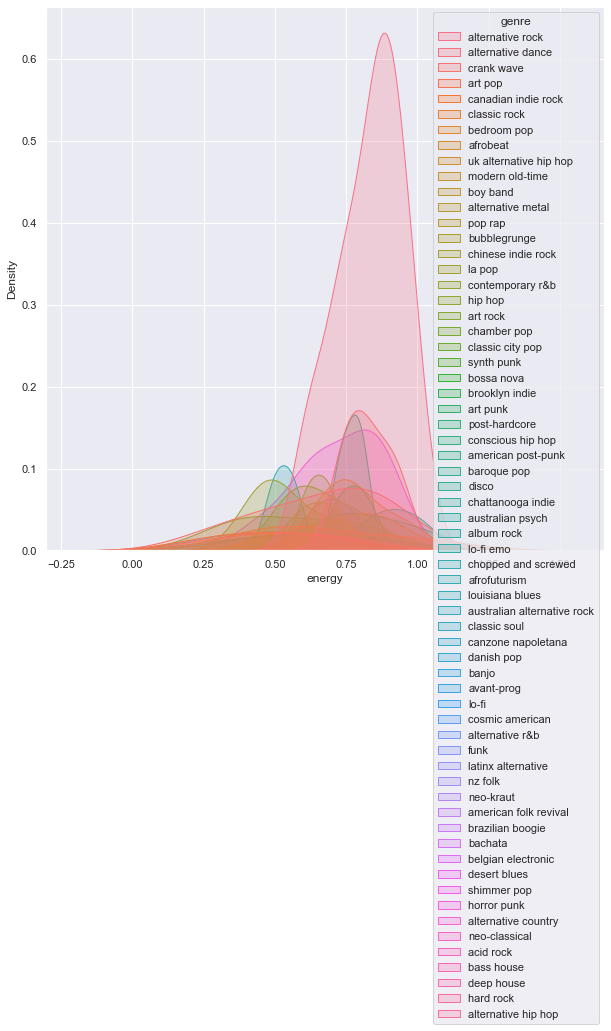

In [24]:
sns.set(rc = {'figure.figsize':(10,10)})
sns.kdeplot(data=running_playlist, x='energy', hue='genre', fill=True)

In [27]:
running_playlist['genre'].value_counts()


alternative rock       27
desert blues            9
crank wave              7
alternative dance       6
chamber pop             4
                       ..
louisiana blues         1
pop rap                 1
classic soul            1
canzone napoletana      1
alternative hip hop     1
Name: genre, Length: 64, dtype: int64

### Popular running playlists:
- Runner's world, best songs of the year: 6FAsnaUOkxS1MCXpNQEsVn
- Runner's world, best running songs: 6r6adsTGyPpmsE8c7glVWy
- Emma Bates: 0opnkJJa0mVhBX52ZAlerJ
- spotify's running mix: 37i9dQZF1EIdThJL1CyWNZ


Adding these based on my own genre preferences and BPMs
- spotify's rock me up: 37i9dQZF1DX0wiundViT27
- spotify's run wild (indie stuff): 37i9dQZF1DX35oM5SPECmN
- spotify's born to run 150 BPM: 37i9dQZF1DX0hWmn8d5pRe
- spotify's indie running: 37i9dQZF1DWZq91oLsHZvy
- spotify's run fast made for me:37i9dQZF1EIgRH0dVPAgL9
- spotify's indie running mix: 37i9dQZF1EIhB2mnQjOo25
- spotify's dance running mix: 37i9dQZF1EIfClyn4w4z31

In [138]:
runnersworld1 = call_playlist('spotify', '6FAsnaUOkxS1MCXpNQEsVn')
runnersworld2 = call_playlist('spotify', '6r6adsTGyPpmsE8c7glVWy')
emma_bates = call_playlist('spotify', '0opnkJJa0mVhBX52ZAlerJ')
runningmix = call_playlist('spotify', '37i9dQZF1EIdThJL1CyWNZ')
highenergyworkout = call_playlist('spotify', '37i9dQZF1EIeLflS1D0w73')
rockmeup = call_playlist('spotify', '37i9dQZF1DX0wiundViT27')
ruunwild = call_playlist('spotify', '37i9dQZF1DX35oM5SPECmN')
born2run = call_playlist('spotify', '37i9dQZF1DX0hWmn8d5pRe')
indierunning = call_playlist('spotify', '37i9dQZF1DWZq91oLsHZvy')
runfast = call_playlist('spotify', '37i9dQZF1EIgRH0dVPAgL9')
indierunningmix = call_playlist('spotify', '37i9dQZF1EIhB2mnQjOo25')
dancerunningmix = call_playlist('spotify', '37i9dQZF1EIfClyn4w4z31')

In [42]:
runnersworld1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   artist            29 non-null     object
 1   album             29 non-null     object
 2   track_name        29 non-null     object
 3   track_id          29 non-null     object
 4   duration_ms       29 non-null     object
 5   acousticness      29 non-null     object
 6   danceability      29 non-null     object
 7   energy            29 non-null     object
 8   instrumentalness  29 non-null     object
 9   key               29 non-null     object
 10  liveness          29 non-null     object
 11  loudness          29 non-null     object
 12  mode              29 non-null     object
 13  speechiness       29 non-null     object
 14  tempo             29 non-null     object
 15  valence           29 non-null     object
 16  time_signature    29 non-null     object
dtypes: object(17)
memo

In [139]:
other_playlists = [runnersworld1, runnersworld2, emma_bates, runningmix, rockmeup, ruunwild, born2run, indierunning,
                  runfast, indierunningmix, dancerunningmix]
other_merged = highenergyworkout

In [140]:
for df in other_playlists:
  other_merged = pd.merge(other_merged, df, how='outer')

C:\Users\AJ\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:916: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  key_col = Index(lvals).where(~mask_left, rvals)
C:\Users\AJ\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:916: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  key_col = Index(lvals).where(~mask_left, rvals)
C:\Users\AJ\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:916: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  key_col = Index(lvals).where(~mask_left, rvals)
C:\Users\AJ\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:916: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed obje

In [141]:
other_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 624 entries, 0 to 623
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   artist            624 non-null    object
 1   album             624 non-null    object
 2   track_name        624 non-null    object
 3   track_id          624 non-null    object
 4   duration_ms       624 non-null    object
 5   acousticness      624 non-null    object
 6   danceability      624 non-null    object
 7   energy            624 non-null    object
 8   instrumentalness  624 non-null    object
 9   key               624 non-null    object
 10  liveness          624 non-null    object
 11  loudness          624 non-null    object
 12  mode              624 non-null    object
 13  speechiness       624 non-null    object
 14  tempo             624 non-null    object
 15  valence           624 non-null    object
 16  time_signature    624 non-null    object
dtypes: object(17)
me

In [142]:
other_merged['genre'] = other_merged['artist'].apply(lambda x: get_artist_genre(x))
other_merged.head()

,artist,album,track_name,track_id,duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,time_signature,genre
0,Tate McRae,greedy,greedy,3rUGC1vUpkDG9CZFHMur1t,131872.0,0.256,0.75,0.733,0.0,6.0,0.114,-3.18,0.0,0.0319,111.018,0.844,1.0,pop
1,Imanbek,Belly Dancer,Belly Dancer,7fZBQnc0zXwVybgCIrQQil,151475.0,0.0582,0.845,0.797,0.000006,1.0,0.167,-4.984,1.0,0.139,121.985,0.422,4.0,electro house
2,Armin van Buuren,Feel Again,On & On,6wLqNGHQIja6xqT0cfrzBB,170578.0,0.0221,0.681,0.933,0.00504,0.0,0.266,-2.855,1.0,0.104,128.036,0.46,4.0,dutch trance
3,Sia,This Is Acting,Unstoppable,2J2Z1SkXYghSajLibnQHOa,217747.0,0.112,0.468,0.779,0.000373,9.0,0.101,-4.839,1.0,0.0779,173.799,0.26,4.0,australian dance
4,Dua Lipa,Dance The Night (From Barbie The Album),Dance The Night - From Barbie The Album,1vYXt7VSjH9JIM5oRRo7vA,176579.0,0.0207,0.671,0.845,0.0,11.0,0.329,-4.93,0.0,0.048,110.056,0.775,4.0,dance pop


### Examine my playlist
What are some of the features that I like??

One idea could be to go into my history and count the number of plays for each track. That would give me an idea of what songs I like to listen to. 

In [51]:
df.head(4)

,ts,ms_played,track_name,artist_name,album_name,track_id,reason_start,reason_end,shuffle,skipped
0,2020-11-17T20:48:19Z,1346,Performing Human (Eaters Mix),Parquet Courts,Performing Human,7xoBFyaqfOEoWtuEsmCKV,fwdbtn,fwdbtn,True,NaN
1,2020-11-17T20:48:20Z,139,Ballerina - 1999 Remaster,Van Morrison,Astral Weeks,4QKk0GijhiDBcoRLeZvdZZ,fwdbtn,fwdbtn,True,NaN
2,2020-11-17T20:48:20Z,1462,Not to Touch the Earth - Live,The Doors,Absolutely Live,7alVFPjibA7YdDlbm00Y9J,fwdbtn,fwdbtn,True,NaN
3,2020-11-17T20:48:20Z,2205,Supersonic - Remastered,Oasis,Definitely Maybe (Deluxe Edition Remastered),4jJfa4mO5JjV9Tz2aAxE2M,fwdbtn,fwdbtn,True,NaN


In [63]:
history_playcount = df.groupby(['track_name', 'track_id']).size().reset_index(name='playcount')

In [64]:
history_playcount.head()

,track_name,track_id,playcount
0,#2,7lLv6f8cEeVYp8d5YBXqyx,1
1,#3,2Bc4llhjJBW77I552RgA3L,5
2,#findfrank,6aShIrvjDN2qFuf1fYpBz,1
3,$$$,3fnDeGnEgJhPRXzr6Iud7,2
4,$$$ (Audiotree Live Version),0J3zk2CKxUkBOHS6LDAIj,6


In [68]:
# merged the playcount onto running playlist df
running_playlist = running_playlist.merge(history_playcount[['track_id', 'playcount']], on='track_id', how='left')
running_playlist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148 entries, 0 to 147
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist            148 non-null    object 
 1   album             148 non-null    object 
 2   track_name        148 non-null    object 
 3   track_id          148 non-null    object 
 4   duration_ms       148 non-null    object 
 5   acousticness      148 non-null    object 
 6   danceability      148 non-null    object 
 7   energy            148 non-null    object 
 8   instrumentalness  148 non-null    object 
 9   key               148 non-null    object 
 10  liveness          148 non-null    object 
 11  loudness          148 non-null    object 
 12  mode              148 non-null    object 
 13  speechiness       148 non-null    object 
 14  tempo             148 non-null    object 
 15  valence           148 non-null    object 
 16  time_signature    148 non-null    object 
 1

In [69]:
running_playlist.head()

,artist,album,track_name,track_id,duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,time_signature,genre,playcount
0,Parquet Courts,Light Up Gold,Stoned And Starving,6CSAKVMzk60vOfG0MJMC6v,311680,0.274,0.236,0.882,0.875,5,0.131,-7.426,1,0.0586,169.735,0.29,4,alternative rock,33.0
1,LCD Soundsystem,45:33,45:33,4jfJb4I62fGIRrhbClYcHG,2764934,0.138,0.478,0.897,0.657,7,0.1,-6.554,1,0.0471,113.018,0.186,4,alternative dance,36.0
2,"Black Country, New Road",Sunglasses,Sunglasses,65UwL8cFTFyMA8uh1nr95p,533739,0.173,0.476,0.499,0.000019,6,0.129,-6.66,0,0.0746,117.013,0.197,4,crank wave,NaN
3,Cate Le Bon,Crab Day,What's Not Mine,3BZ17mVqFNdmwVANwAemVj,446627,0.492,0.732,0.378,0.193,0,0.0686,-6.679,1,0.0502,89.446,0.964,4,art pop,61.0
4,Nap Eyes,Thought Rock Fish Scale,Stargazer,3rvwOMySfAueAGr2EG4ydu,253105,0.257,0.81,0.333,0.000098,7,0.0909,-11.903,1,0.0387,115.836,0.699,4,canadian indie rock,109.0


The dtypes need to changed:
-track_id             object
- popularity            int64
- duration_ms           int64
- danceability        float64
- energy              float64
- key                   int64
- loudness            float64
- speechiness         float64
- acousticness        float64
- instrumentalness    float64
- liveness            float64
- valence             float64
- tempo               float64
- time_signature        int64
- track_genre          object


In [98]:
running_playlist['duration_ms'] = running_playlist['duration_ms'].astype(int)
running_playlist['acousticness'] = running_playlist['acousticness'].astype(float)
running_playlist['danceability'] = running_playlist['danceability'].astype(float)
running_playlist['energy'] = running_playlist['energy'].astype(float)
running_playlist['instrumentalness'] = running_playlist['instrumentalness'].astype(float)
running_playlist['key'] = running_playlist['key'].astype(int)
running_playlist['liveness'] = running_playlist['liveness'].astype(float)
running_playlist['loudness'] = running_playlist['loudness'].astype(float)
running_playlist['mode'] = running_playlist['mode'].astype(int)
running_playlist['speechiness'] = running_playlist['speechiness'].astype(float)
running_playlist['tempo'] = running_playlist['tempo'].astype(float)
running_playlist['valence'] = running_playlist['valence'].astype(float)
running_playlist['time_signature'] = running_playlist['time_signature'].astype(int)

In [143]:

other_merged['duration_ms'] = other_merged['duration_ms'].astype(int)
other_merged['acousticness'] = other_merged['acousticness'].astype(float)
other_merged['danceability'] = other_merged['danceability'].astype(float)
other_merged['energy'] = other_merged['energy'].astype(float)
other_merged['instrumentalness'] = other_merged['instrumentalness'].astype(float)
other_merged['key'] = other_merged['key'].astype(int)
other_merged['liveness'] = other_merged['liveness'].astype(float)
other_merged['loudness'] = other_merged['loudness'].astype(float)
other_merged['mode'] = other_merged['mode'].astype(int)
other_merged['speechiness'] = other_merged['speechiness'].astype(float)
other_merged['tempo'] = other_merged['tempo'].astype(float)
other_merged['valence'] = other_merged['valence'].astype(float)
other_merged['time_signature'] = other_merged['time_signature'].astype(int)

### Feature engineering
- what is the dist of the playcount 
- every song in my running playlist should recieve a 1
- all the other pulled songs should get a 0
- I can also use spotipys recommedation to get a few more tracks

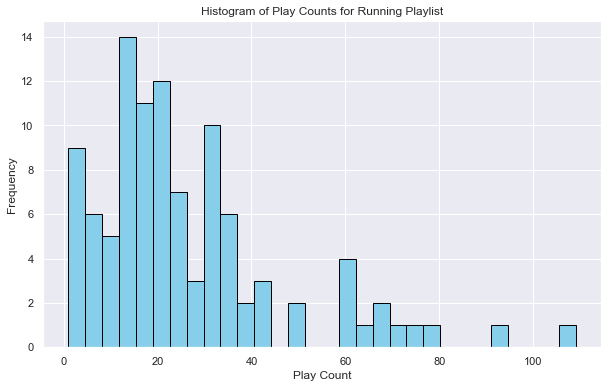

In [73]:
plt.figure(figsize=(10, 6))  # Set the size of the plot
running_playlist['playcount'].hist(color='skyblue', bins=30, edgecolor='black') 
plt.title('Histogram of Play Counts for Running Playlist')  
plt.xlabel('Play Count')  
plt.ylabel('Frequency')  
plt.grid(True)  
plt.show()

I'm gonna say any song that has a play count of under 25 plays was not one of my favorites. 

In [100]:
running_playlist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148 entries, 0 to 147
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist            148 non-null    object 
 1   album             148 non-null    object 
 2   track_name        148 non-null    object 
 3   track_id          148 non-null    object 
 4   duration_ms       148 non-null    int32  
 5   acousticness      148 non-null    float64
 6   danceability      148 non-null    float64
 7   energy            148 non-null    float64
 8   instrumentalness  148 non-null    float64
 9   key               148 non-null    int32  
 10  liveness          148 non-null    float64
 11  loudness          148 non-null    float64
 12  mode              148 non-null    int32  
 13  speechiness       148 non-null    float64
 14  tempo             148 non-null    float64
 15  valence           148 non-null    float64
 16  time_signature    148 non-null    int32  
 1

[Text(0, 0, 'Parquet Courts'),
 Text(1, 0, 'Nap Eyes'),
 Text(2, 0, 'Mdou Moctar'),
 Text(3, 0, 'Viagra Boys'),
 Text(4, 0, 'The Killers'),
 Text(5, 0, 'DEVO'),
 Text(6, 0, 'LCD Soundsystem'),
 Text(7, 0, 'Smog'),
 Text(8, 0, 'Luke Kelly'),
 Text(9, 0, 'Lou Reed'),
 Text(10, 0, 'Yard Act'),
 Text(11, 0, 'Aminé'),
 Text(12, 0, 'Grateful Dead'),
 Text(13, 0, 'Julia Jacklin'),
 Text(14, 0, 'Black Country, New Road')]

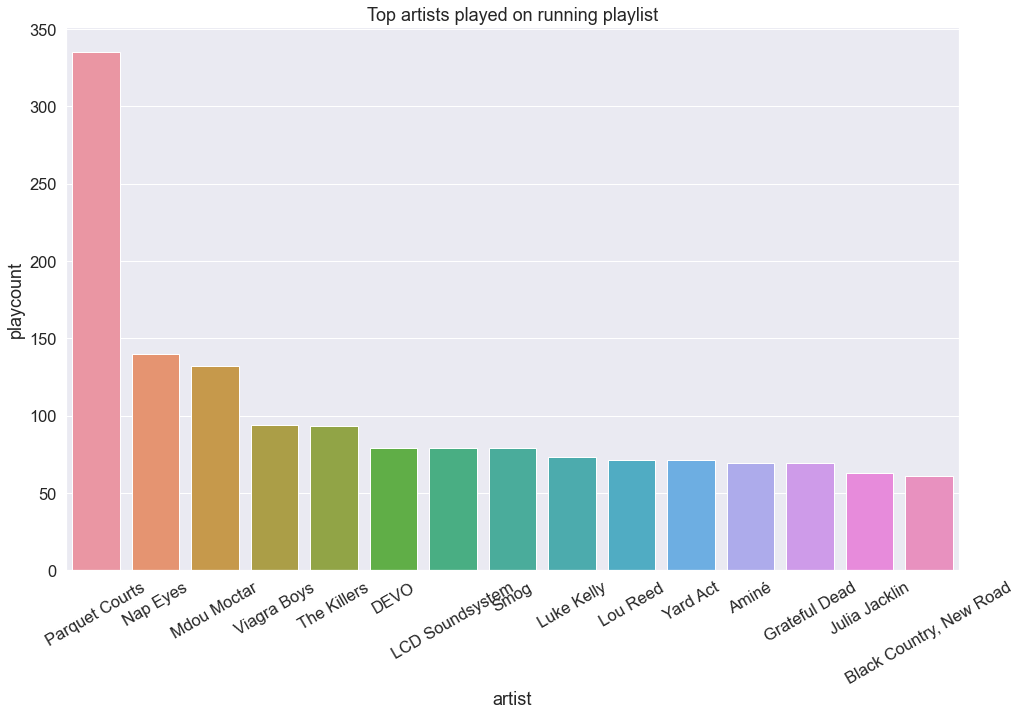

In [103]:
# who were my 15 top streamed artists? 

top_15_artists = running_playlist.groupby('artist')['playcount'].sum().nlargest(15).reset_index()

sns.set(rc={'figure.figsize':(16,10)})
sns.set(style='whitegrid')
sns.set(font_scale=1.5)
g = sns.barplot(x='artist', y='playcount', data=top_15_artists)
g.set_title('Top artists played on running playlist')
g.set_xticklabels(g.get_xticklabels(), rotation=30)

[Text(0, 0, 'Stargazer'),
 Text(1, 0, 'Total Football'),
 Text(2, 0, 'The Well'),
 Text(3, 0, 'Raglan Road'),
 Text(4, 0, '100% Endurance'),
 Text(5, 0, 'DR. WHOEVER'),
 Text(6, 0, 'Ripple - 2013 Remaster'),
 Text(7, 0, 'Pressure To Party'),
 Text(8, 0, "Ain't Nice"),
 Text(9, 0, 'Concorde'),
 Text(10, 0, 'Tenderness'),
 Text(11, 0, "What's Not Mine"),
 Text(12, 0, 'Chaise Longue'),
 Text(13, 0, 'The Blue Mask'),
 Text(14, 0, 'It Just Doesn’t Matter')]

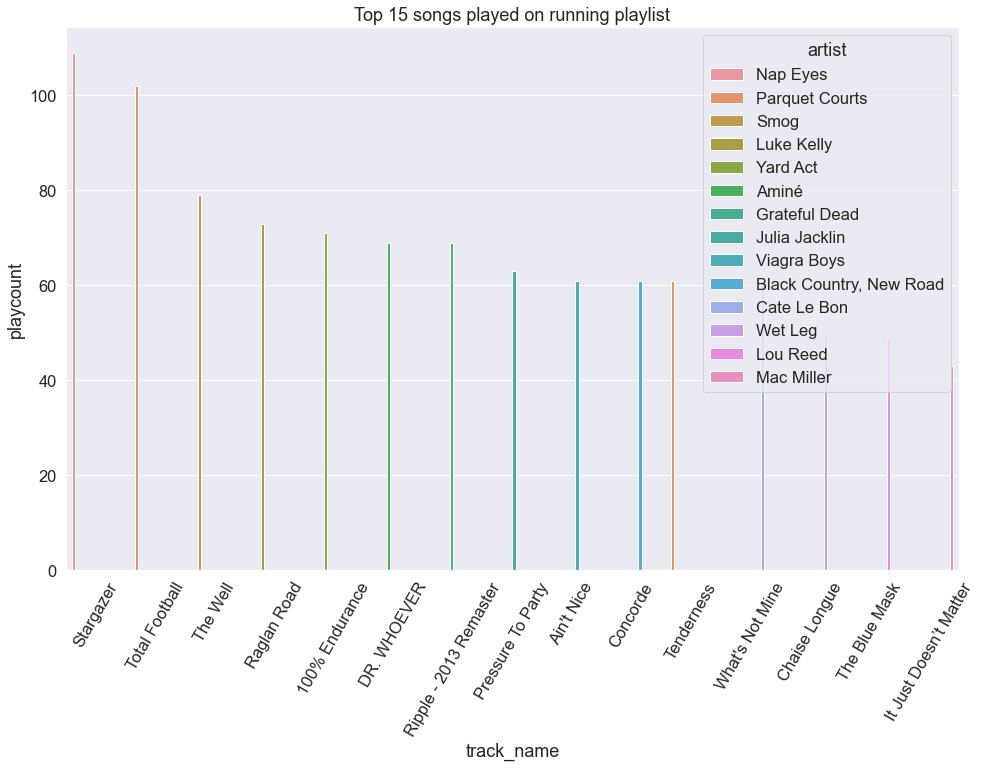

In [123]:
# who were my 15 top streamed tracks? 

top_15_songs = running_playlist.groupby(['track_name','artist'])['playcount'].sum().nlargest(15).reset_index()

sns.set(rc={'figure.figsize':(16,10)})
sns.set(style='whitegrid')
sns.set(font_scale=1.5)
g = sns.barplot(x='track_name', y='playcount', hue='artist', data=top_15_songs)
g.set_title('Top 15 songs played on running playlist')
g.set_xticklabels(g.get_xticklabels(), rotation=60)

[Text(0, 0, 'alternative rock'),
 Text(1, 0, 'crank wave'),
 Text(2, 0, 'canadian indie rock'),
 Text(3, 0, 'desert blues'),
 Text(4, 0, 'alternative dance'),
 Text(5, 0, 'classic rock'),
 Text(6, 0, 'alternative country'),
 Text(7, 0, 'boy band'),
 Text(8, 0, 'hip hop'),
 Text(9, 0, 'banjo')]

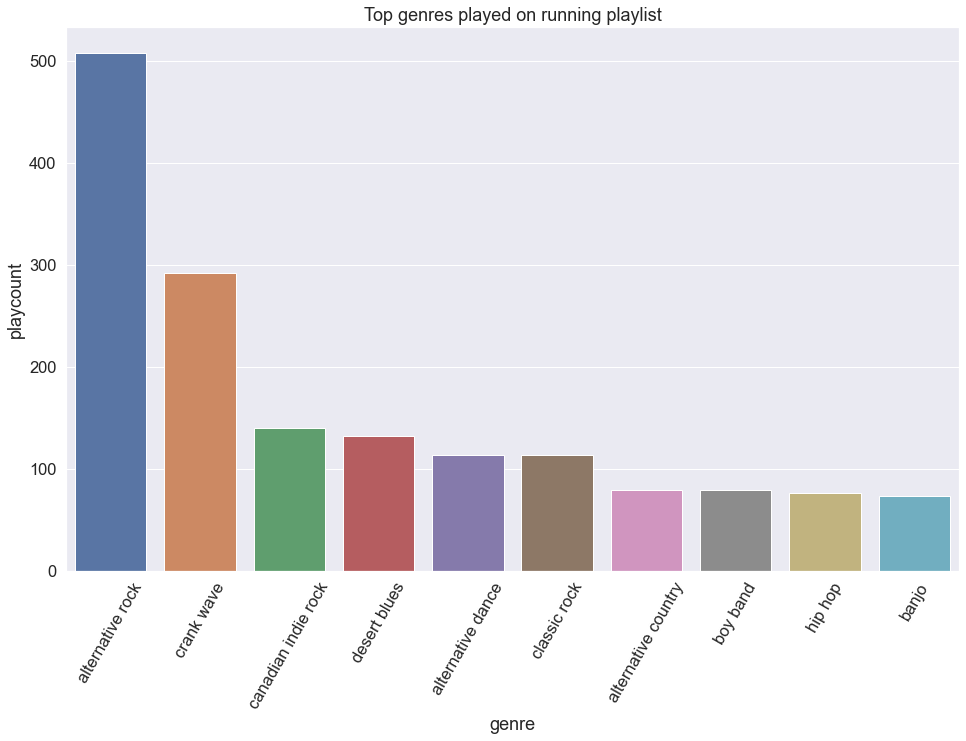

In [124]:
# who were my 5 top streamed genres? 

top_10_genre = running_playlist.groupby('genre')['playcount'].sum().nlargest(10).reset_index()

sns.set(rc={'figure.figsize':(16,10)})
sns.set(style='whitegrid')
sns.set(font_scale=1.5)
g = sns.barplot(x='genre', y='playcount', data=top_5_genre)
g.set_title('Top genres played on running playlist')
g.set_xticklabels(g.get_xticklabels(), rotation=60)

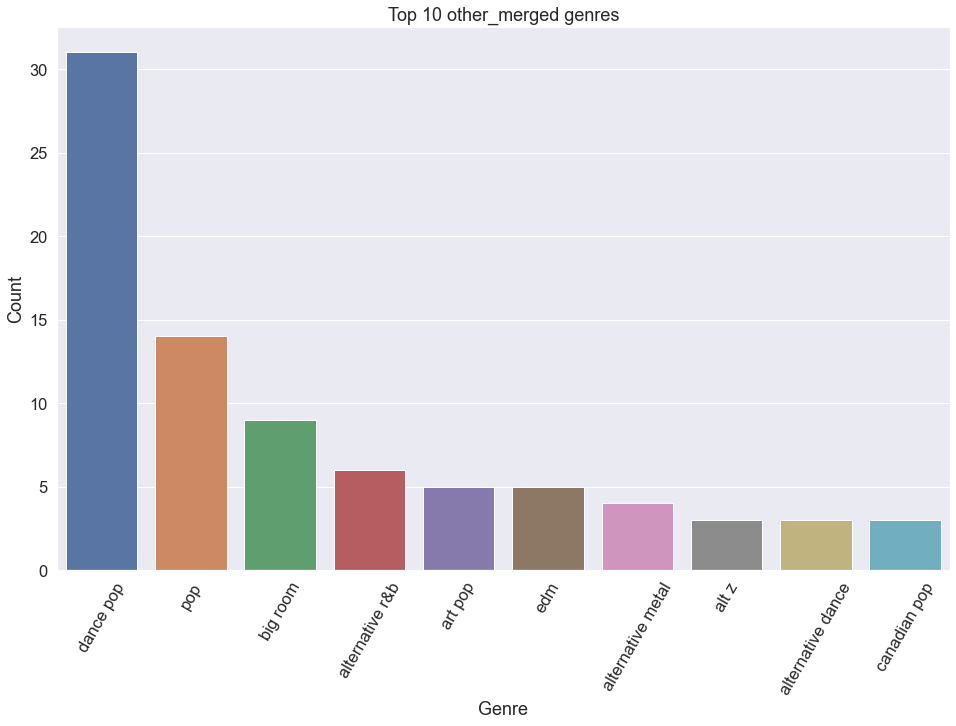

In [137]:
# genres by other merged playlist 
top_10_genre = other_merged['genre'].value_counts().nlargest(10).reset_index()

sns.set(rc={'figure.figsize':(16,10)})
sns.set(style='whitegrid')
sns.set(font_scale=1.5)
g = sns.barplot(x='index', y='genre', data=top_10_genre)
g.set_title('Top 10 other_merged genres')
g.set_xlabel('Genre')
g.set_ylabel('Count')
g.set_xticklabels(g.get_xticklabels(), rotation=60)

# Show plot
plt.show()

#### exploring audiofeatures
- Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
- A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
- Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
- Instrumentalness Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
- Livness Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
- Loudness The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.
- Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
- Tempo The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
-  Valence A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

<AxesSubplot:>

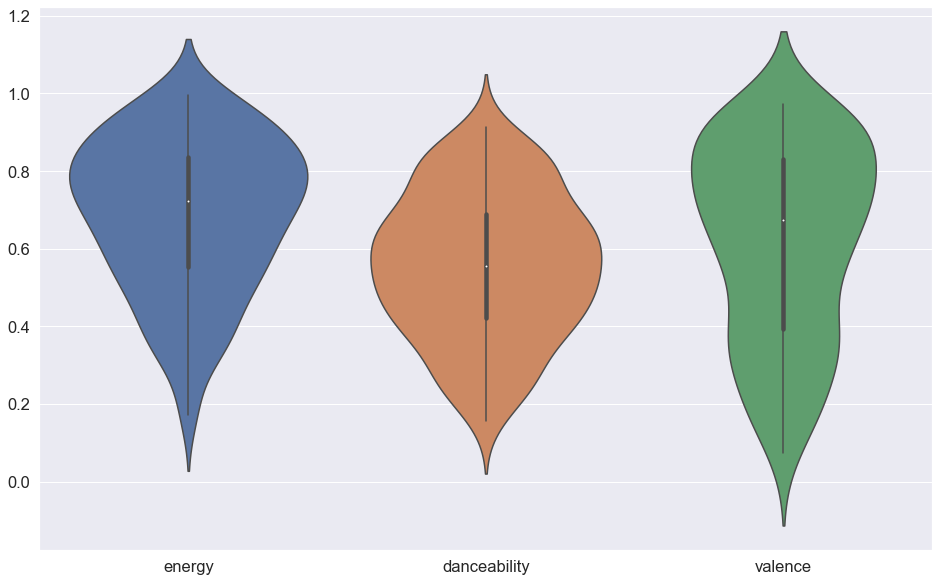

In [131]:
# violin plots to explore audio features 
sns.violinplot(data=running_playlist[['energy', 'danceability', 'valence']])

<AxesSubplot:>

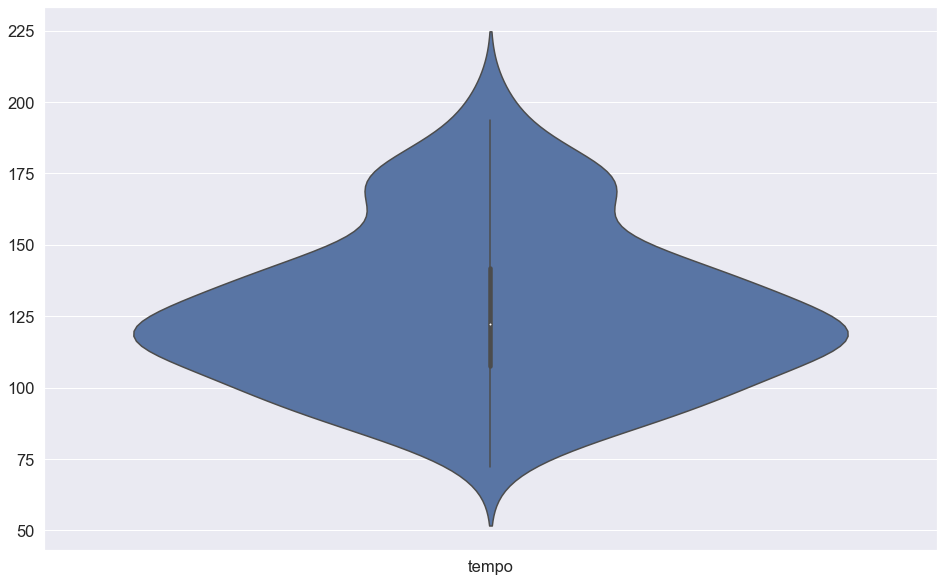

In [128]:
sns.violinplot(data=running_playlist[['tempo']])

<AxesSubplot:>

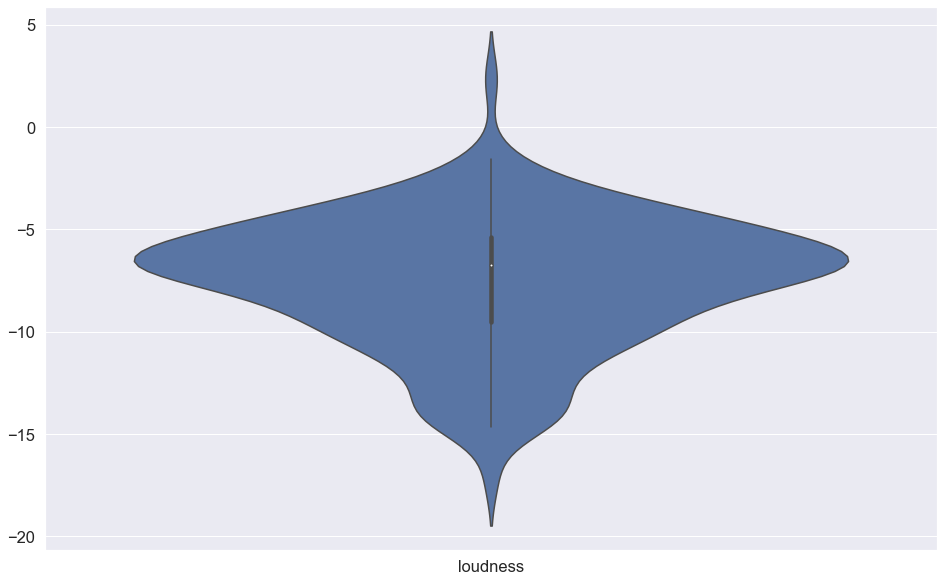

In [132]:
sns.violinplot(data=running_playlist[['loudness']])

### how do the playlists compare?


In [144]:
my_plaliststats = running_playlist.describe()
otherstats = other_merged.describe()

In [148]:
my_plaliststats

,duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,time_signature,playcount
count,1.480000e+02,148.000000,148.000000,148.000000,148.000000,148.00000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,102.000000
mean,2.898489e+05,0.229047,0.555736,0.686412,0.183678,5.50000,0.163600,-7.545399,0.763514,0.074996,127.080439,0.616993,3.891892,26.372549
std,2.581655e+05,0.274996,0.185494,0.196249,0.286550,3.40967,0.144612,3.167536,0.426367,0.070106,28.009230,0.252934,0.311571,20.785525
min,8.517300e+04,0.000109,0.157000,0.172000,0.000000,0.00000,0.036000,-17.139000,0.000000,0.025500,72.306000,0.072800,3.000000,1.000000
25%,1.907735e+05,0.010215,0.422500,0.554000,0.000063,2.00000,0.084650,-9.506000,1.000000,0.038575,107.517500,0.393250,4.000000,12.000000
50%,2.451470e+05,0.099750,0.554500,0.722500,0.005665,6.00000,0.110000,-6.762000,1.000000,0.047750,122.310000,0.674000,4.000000,21.000000
75%,2.996935e+05,0.409500,0.689750,0.836500,0.272250,8.25000,0.159500,-5.350750,1.000000,0.081200,141.995750,0.831250,4.000000,33.000000
max,2.764934e+06,0.993000,0.913000,0.996000,0.940000,11.00000,0.871000,2.343000,1.000000,0.409000,204.113000,0.974000,4.000000,109.000000


In [149]:
otherstats

,duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,time_signature
count,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000
mean,211236.785256,0.075569,0.603437,0.800859,0.046127,5.362179,0.192553,-5.504037,0.612179,0.078326,129.657159,0.570556,3.975962
std,53589.393931,0.130013,0.134149,0.129144,0.153481,3.595107,0.144799,2.096060,0.487644,0.062960,25.162883,0.207823,0.221767
min,109109.000000,0.000004,0.128000,0.318000,0.000000,0.000000,0.026000,-15.544000,0.000000,0.023700,65.043000,0.054600,1.000000
25%,177680.750000,0.002968,0.515000,0.724750,0.000000,2.000000,0.091100,-6.385000,0.000000,0.040450,114.059500,0.407000,4.000000
50%,204186.500000,0.020500,0.601000,0.832000,0.000094,6.000000,0.128500,-5.104500,1.000000,0.055650,126.026000,0.577000,4.000000
75%,231470.250000,0.080400,0.694000,0.897000,0.004312,8.250000,0.284250,-4.210250,1.000000,0.089225,148.040250,0.732750,4.000000
max,622000.000000,0.754000,0.966000,0.994000,0.963000,11.000000,0.882000,1.334000,1.000000,0.463000,207.920000,0.975000,5.000000


In [166]:
# dropping playcount for easier merge of playlists for comparison
# merged_df = pd.merge(df1, df2, on='category', suffixes=('_df1', '_df2'))
myrun_merge = running_playlist.drop(columns={'playcount'})
combined_playlist = pd.merge(myrun_merge, other_merged, on='duration_ms', how='outer', suffixes=('_aj', '_spotify'))

In [167]:
combined_playlist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 770 entries, 0 to 769
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   artist_aj                 148 non-null    object 
 1   album_aj                  148 non-null    object 
 2   track_name_aj             148 non-null    object 
 3   track_id_aj               148 non-null    object 
 4   duration_ms               770 non-null    int32  
 5   acousticness_aj           148 non-null    float64
 6   danceability_aj           148 non-null    float64
 7   energy_aj                 148 non-null    float64
 8   instrumentalness_aj       148 non-null    float64
 9   key_aj                    148 non-null    float64
 10  liveness_aj               148 non-null    float64
 11  loudness_aj               148 non-null    float64
 12  mode_aj                   148 non-null    float64
 13  speechiness_aj            148 non-null    float64
 14  tempo_aj  

In [168]:
combined_playlist.head()

,artist_aj,album_aj,track_name_aj,track_id_aj,duration_ms,acousticness_aj,danceability_aj,energy_aj,instrumentalness_aj,key_aj,...,instrumentalness_spotify,key_spotify,liveness_spotify,loudness_spotify,mode_spotify,speechiness_spotify,tempo_spotify,valence_spotify,time_signature_spotify,genre_spotify
0,Parquet Courts,Light Up Gold,Stoned And Starving,6CSAKVMzk60vOfG0MJMC6v,311680,0.274,0.236,0.882,0.875000,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LCD Soundsystem,45:33,45:33,4jfJb4I62fGIRrhbClYcHG,2764934,0.138,0.478,0.897,0.657000,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Black Country, New Road",Sunglasses,Sunglasses,65UwL8cFTFyMA8uh1nr95p,533739,0.173,0.476,0.499,0.000019,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Cate Le Bon,Crab Day,What's Not Mine,3BZ17mVqFNdmwVANwAemVj,446627,0.492,0.732,0.378,0.193000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Nap Eyes,Thought Rock Fish Scale,Stargazer,3rvwOMySfAueAGr2EG4ydu,253105,0.257,0.810,0.333,0.000098,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

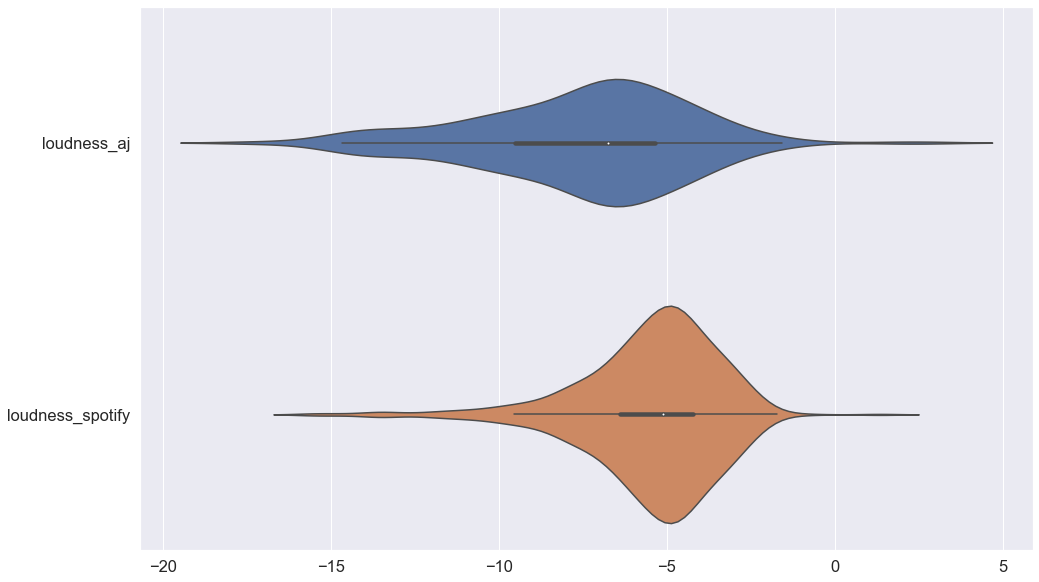

In [176]:
sns.violinplot(data=combined_playlist[['loudness_aj', 'loudness_spotify']], orient='h')

<AxesSubplot:>

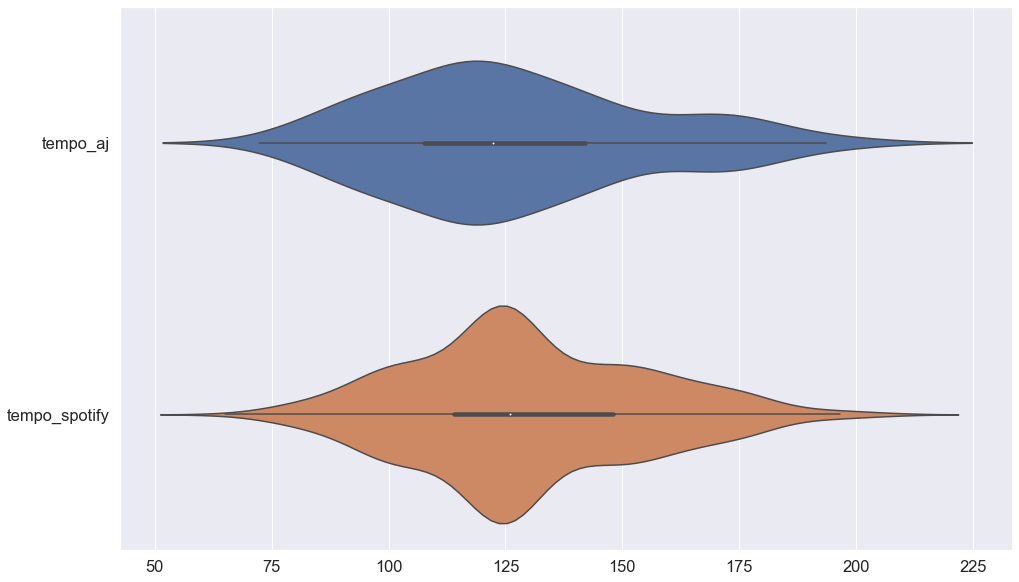

In [175]:
sns.violinplot(data=combined_playlist[['tempo_aj', 'tempo_spotify']], orient='h')

<AxesSubplot:>

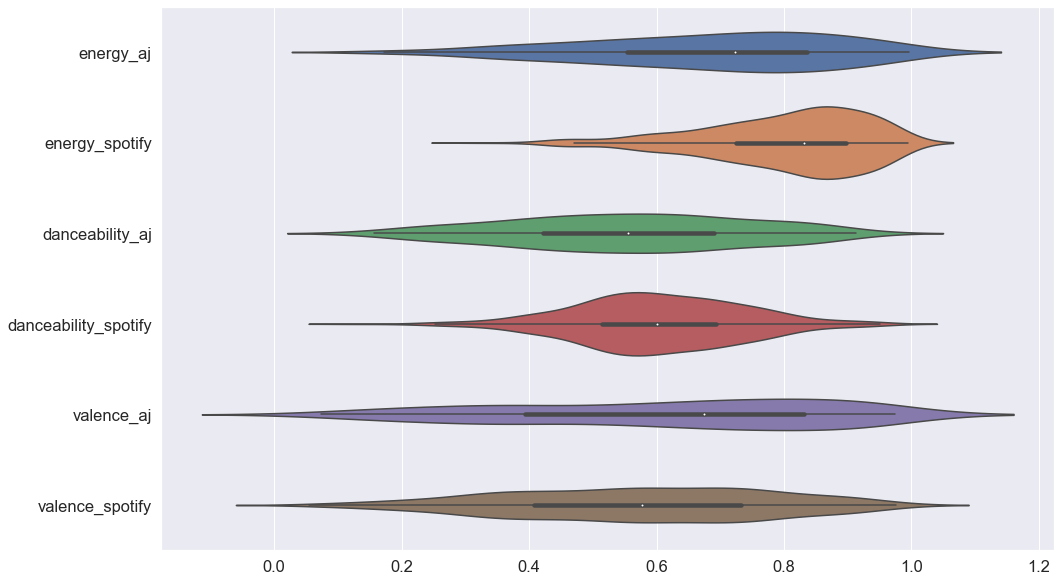

In [183]:
sns.violinplot(data=combined_playlist[['energy_aj','energy_spotify', 'danceability_aj',
                                       'danceability_spotify', 'valence_aj', 'valence_spotify']], orient='h')

<AxesSubplot:>

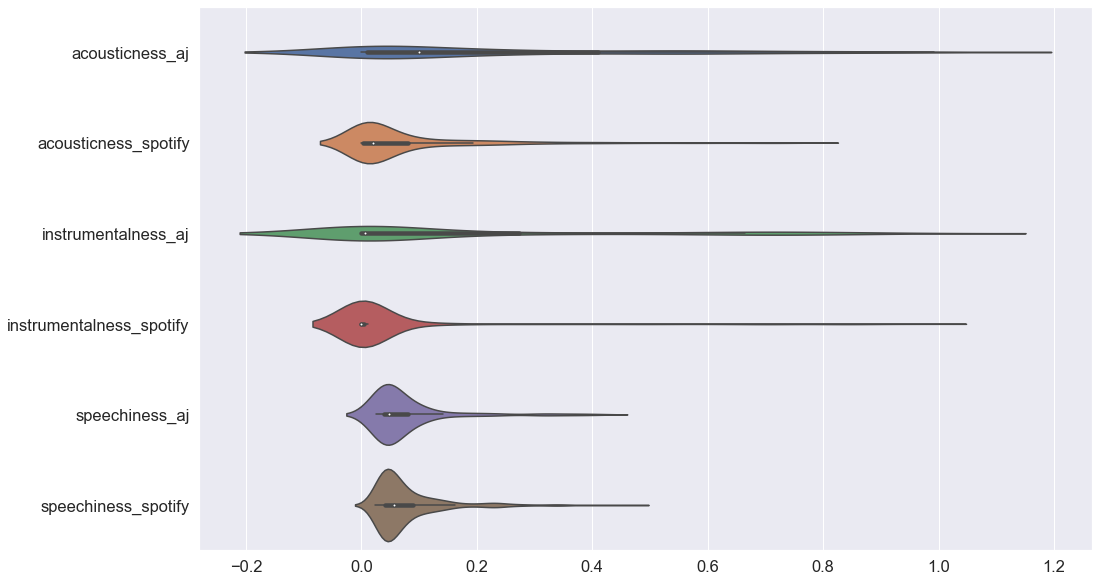

In [182]:
sns.violinplot(data=combined_playlist[['acousticness_aj','acousticness_spotify', 'instrumentalness_aj',
                                       'instrumentalness_spotify', 'speechiness_aj', 
                                       'speechiness_spotify']], orient='h')

### Check what songs appear in spotify history. 
As apart of the feature engineering I'm going to see what songs have appeared in my history. If they've appear it can be assumed that I like the song(s)

In [205]:
# first I need to reduce the size of the history df
# drop dups is one way
df = df.drop_duplicates(subset='track_id', keep='first').reset_index(drop=True)
other_merged = other_merged.drop_duplicates(subset='track_id', keep='first').reset_index(drop=True)

In [206]:
df['track_id'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 17222 entries, 0 to 17221
Series name: track_id
Non-Null Count  Dtype 
--------------  ----- 
17221 non-null  object
dtypes: object(1)
memory usage: 134.7+ KB


In [209]:
# get audio features for history 
def get_audio_features(track_id):
    return sp.audio_features(track_id)

In [213]:
# Define a function to split a list into chunks
def chunks(lst, chunk_size):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), chunk_size):
        yield lst[i:i + chunk_size]

# Convert track IDs to strings
track_ids = df['track_id'].astype(str).tolist()

# Define chunk size for batch processing
chunk_size = 50  # You can adjust this value as needed

# Split the list of track IDs into smaller batches
track_id_batches = list(chunks(track_ids, chunk_size))

# Initialize an empty list to store audio features
audio_features_list = []

In [221]:
# Iterate over each batch of track IDs and fetch audio features
for batch in track_id_batches:
    audio_features_batch = sp.audio_features(batch)
    audio_features_list.extend(audio_features_batch)

# Convert the list of dictionaries into a DataFrame
audio_features_df = pd.DataFrame(audio_features_list)

In [222]:
audio_features_df.to_csv('df_features.csv', index=False)

In [224]:
audio_features_df.head()

,0
0,None
1,"{'danceability': 0.443, 'energy': 0.388, 'key'..."
2,"{'danceability': 0.475, 'energy': 0.64, 'key':..."
3,"{'danceability': 0.359, 'energy': 0.913, 'key'..."
4,"{'danceability': 0.654, 'energy': 0.95, 'key':..."


In [267]:
df_audiofeatures = pd.read_csv('df_features_cleaned.csv')
df_audiofeatures = df_audiofeatures.dropna()
df_audiofeatures.head(10)

,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,4QKk0GijhiDBcoRLeZvdZZ,0.443,0.388,7.0,-15.002,1.0,0.0293,0.561000,0.000411,0.0618,0.5450,134.504,423280.0,4
1,7alVFPjibA7YdDlbm00Y9J,0.475,0.640,9.0,-9.191,0.0,0.0467,0.052300,0.010600,0.1890,0.2030,132.006,254333.0,4
2,4jJfa4mO5JjV9Tz2aAxE2M,0.359,0.913,9.0,-2.865,1.0,0.0391,0.000063,0.012100,0.0954,0.5890,104.058,283787.0,4
3,20bJBbPapGQ4bqs0YcA9xY,0.654,0.950,1.0,-3.163,1.0,0.1370,0.002230,0.000000,0.4060,0.3510,140.009,228027.0,4
4,2tpTRRc6XFZcwdZlc3hf02,0.290,0.732,2.0,-8.442,1.0,0.0389,0.000247,0.015900,0.4700,0.2750,78.667,245654.0,4
5,6NGvyhGjKSKkyN3yc4YNhD,0.443,0.865,4.0,-4.547,1.0,0.0391,0.007240,0.000116,0.4680,0.4740,110.008,203880.0,4
6,7aqqkpCbBHt0csewgRyMvC,0.505,0.741,8.0,-6.814,0.0,0.0266,0.003680,0.482000,0.1290,0.4990,96.019,297320.0,4
7,05x87u1eIM6U0xmDkqWuKe,0.626,0.361,1.0,-8.681,1.0,0.0334,0.069800,0.000267,0.1440,0.0359,114.934,293185.0,4
8,35BjbTIMBgJvlHmKupLit8,0.598,0.560,10.0,-7.249,1.0,0.0414,0.279000,0.000000,0.2650,0.7890,118.004,194213.0,4
10,4fi5KJ7cA8A4ivm9PdTvCX,0.554,0.329,5.0,-13.648,1.0,0.0297,0.760000,0.129000,0.1010,0.6290,169.718,122441.0,4


In [268]:
df_audiofeatures = df_audiofeatures.drop_duplicates(subset='track_id', keep='first').reset_index(drop=True)

In [269]:
df_audiofeatures['track_id'] = df_audiofeatures['track_id'].str.strip()

In [270]:
df_audiofeatures.head()

,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,4QKk0GijhiDBcoRLeZvdZZ,0.443,0.388,7.0,-15.002,1.0,0.0293,0.561000,0.000411,0.0618,0.545,134.504,423280.0,4
1,7alVFPjibA7YdDlbm00Y9J,0.475,0.640,9.0,-9.191,0.0,0.0467,0.052300,0.010600,0.1890,0.203,132.006,254333.0,4
2,4jJfa4mO5JjV9Tz2aAxE2M,0.359,0.913,9.0,-2.865,1.0,0.0391,0.000063,0.012100,0.0954,0.589,104.058,283787.0,4
3,20bJBbPapGQ4bqs0YcA9xY,0.654,0.950,1.0,-3.163,1.0,0.1370,0.002230,0.000000,0.4060,0.351,140.009,228027.0,4
4,2tpTRRc6XFZcwdZlc3hf02,0.290,0.732,2.0,-8.442,1.0,0.0389,0.000247,0.015900,0.4700,0.275,78.667,245654.0,4


In [271]:
df_audiofeatures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14145 entries, 0 to 14144
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_id           14145 non-null  object 
 1   danceability       14145 non-null  float64
 2    energy            14145 non-null  float64
 3    key               14145 non-null  float64
 4    loudness          14145 non-null  float64
 5   mode               14145 non-null  float64
 6    speechiness       14145 non-null  float64
 7    acousticness      14145 non-null  float64
 8    instrumentalness  14145 non-null  float64
 9    liveness          14145 non-null  float64
 10   valence           14145 non-null  float64
 11   tempo             14145 non-null  float64
 12   duration_ms       14145 non-null  float64
 13   time_signature    14145 non-null  object 
dtypes: float64(12), object(2)
memory usage: 1.5+ MB


In [272]:
history_features = pd.merge(df_audiofeatures, df[['track_id','artist_name','track_name','album_name']], on='track_id',
                           how='left')
history_features.head()

,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,artist_name,track_name,album_name
0,4QKk0GijhiDBcoRLeZvdZZ,0.443,0.388,7.0,-15.002,1.0,0.0293,0.561000,0.000411,0.0618,0.545,134.504,423280.0,4,Van Morrison,Ballerina - 1999 Remaster,Astral Weeks
1,7alVFPjibA7YdDlbm00Y9J,0.475,0.640,9.0,-9.191,0.0,0.0467,0.052300,0.010600,0.1890,0.203,132.006,254333.0,4,The Doors,Not to Touch the Earth - Live,Absolutely Live
2,4jJfa4mO5JjV9Tz2aAxE2M,0.359,0.913,9.0,-2.865,1.0,0.0391,0.000063,0.012100,0.0954,0.589,104.058,283787.0,4,Oasis,Supersonic - Remastered,Definitely Maybe (Deluxe Edition Remastered)
3,20bJBbPapGQ4bqs0YcA9xY,0.654,0.950,1.0,-3.163,1.0,0.1370,0.002230,0.000000,0.4060,0.351,140.009,228027.0,4,Kid Cudi,Just What I Am,Indicud
4,2tpTRRc6XFZcwdZlc3hf02,0.290,0.732,2.0,-8.442,1.0,0.0389,0.000247,0.015900,0.4700,0.275,78.667,245654.0,4,Washed Out,It All Feels Right,Paracosm


In [273]:
history_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14145 entries, 0 to 14144
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_id           14145 non-null  object 
 1   danceability       14145 non-null  float64
 2    energy            14145 non-null  float64
 3    key               14145 non-null  float64
 4    loudness          14145 non-null  float64
 5   mode               14145 non-null  float64
 6    speechiness       14145 non-null  float64
 7    acousticness      14145 non-null  float64
 8    instrumentalness  14145 non-null  float64
 9    liveness          14145 non-null  float64
 10   valence           14145 non-null  float64
 11   tempo             14145 non-null  float64
 12   duration_ms       14145 non-null  float64
 13   time_signature    14145 non-null  object 
 14  artist_name        14144 non-null  object 
 15  track_name         14144 non-null  object 
 16  album_name         141

In [274]:
count = 0
label_list = list()
for id in history_features.track_id:
    if id in other_merged.track_id.values or id in running_playlist.track_id.values:
        count = count + 1
        # 1 to the tracks from history df
        label_list.append(1)
    else:
        # if the track id isnt there it gets a 0
        label_list.append(0)
        
print(f'Number of tracks marked with 1 == {count}')

Number of tracks marked with 1 == 157


In [280]:
history_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14145 entries, 0 to 14144
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_id           14145 non-null  object 
 1   danceability       14145 non-null  float64
 2    energy            14145 non-null  float64
 3    key               14145 non-null  float64
 4    loudness          14145 non-null  float64
 5   mode               14145 non-null  float64
 6    speechiness       14145 non-null  float64
 7    acousticness      14145 non-null  float64
 8    instrumentalness  14145 non-null  float64
 9    liveness          14145 non-null  float64
 10   valence           14145 non-null  float64
 11   tempo             14145 non-null  float64
 12   duration_ms       14145 non-null  float64
 13   time_signature    14145 non-null  object 
 14  artist_name        14144 non-null  object 
 15  track_name         14144 non-null  object 
 16  album_name         141

In [ ]:
# get audio features for history 
def get_audio_features(track_id):
    return sp.audio_features(track_id)

# Define a function to split a list into chunks
def chunks(lst, chunk_size):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), chunk_size):
        yield lst[i:i + chunk_size]

# Convert track IDs to strings
track_ids = df['track_id'].astype(str).tolist()

# Define chunk size for batch processing
chunk_size = 50  # You can adjust this value as needed

# Split the list of track IDs into smaller batches
track_id_batches = list(chunks(track_ids, chunk_size))

# Initialize an empty list to store audio features
audio_features_list = []

# Iterate over each batch of track IDs and fetch audio features
for batch in track_id_batches:
    audio_features_batch = sp.audio_features(batch)
    audio_features_list.extend(audio_features_batch)

# Convert the list of dictionaries into a DataFrame
audio_features_df = pd.DataFrame(audio_features_list)

In [284]:
history_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14145 entries, 0 to 14144
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_id           14145 non-null  object 
 1   danceability       14145 non-null  float64
 2    energy            14145 non-null  float64
 3    key               14145 non-null  float64
 4    loudness          14145 non-null  float64
 5   mode               14145 non-null  float64
 6    speechiness       14145 non-null  float64
 7    acousticness      14145 non-null  float64
 8    instrumentalness  14145 non-null  float64
 9    liveness          14145 non-null  float64
 10   valence           14145 non-null  float64
 11   tempo             14145 non-null  float64
 12   duration_ms       14145 non-null  float64
 13   time_signature    14145 non-null  object 
 14  artist_name        14144 non-null  object 
 15  track_name         14144 non-null  object 
 16  album_name         141

In [293]:
# trying to get the genre for history by batching keeps timing out. 
# instead I'll split the history df into smaller dfs, perfrom the call, and merge them back again
# Calculate the number of rows in each smaller DataFrame
num_rows_per_df = len(history_features) // 30

# Initialize a list to store the smaller DataFrames
smaller_dfs = []

# Split the DataFrame into smaller DataFrames
for i in range(30):
    start_index = i * num_rows_per_df
    end_index = (i + 1) * num_rows_per_df if i < 29 else len(history_features)  # Adjust the end index for the last DataFrame
    smaller_df = history_features[start_index:end_index]
    smaller_dfs.append(smaller_df)

# If there are any remaining rows, add them to the last DataFrame
if len(history_features) % 30 != 0:
    smaller_dfs[-1] = pd.concat([smaller_dfs[-1], history_features[num_rows_per_df * 30:]])

# Now 'smaller_dfs' contains a list of 30 smaller DataFrames

In [297]:
# Iterate over the list of smaller DataFrames
for i, smaller_df in enumerate(smaller_dfs, start=1):
    print(f"Smaller_DataFrame_{i}:")
    print(smaller_df)
    print("\n")

Smaller_DataFrame_1:
                   track_id  danceability   energy   key   loudness  mode  \
0    4QKk0GijhiDBcoRLeZvdZZ         0.443    0.388   7.0    -15.002   1.0   
1    7alVFPjibA7YdDlbm00Y9J         0.475    0.640   9.0     -9.191   0.0   
2    4jJfa4mO5JjV9Tz2aAxE2M         0.359    0.913   9.0     -2.865   1.0   
3    20bJBbPapGQ4bqs0YcA9xY         0.654    0.950   1.0     -3.163   1.0   
4    2tpTRRc6XFZcwdZlc3hf02         0.290    0.732   2.0     -8.442   1.0   
..                      ...           ...      ...   ...        ...   ...   
466  35NWDxnzlmxAJq4CfbQAL2         0.560    0.708   5.0     -6.476   1.0   
467  704nmjOWQwwa8jrb7fo8o2         0.402    0.702   1.0     -8.702   1.0   
468  42Z8moYh30XOVffltDDUgK         0.548    0.412   2.0     -7.398   1.0   
469  2ypNOrktGToF0ktbU1BTEB         0.382    0.601   9.0     -5.853   1.0   
470  7kp8VU9fH1q2Srxk7eHGpT         0.553    0.779   9.0     -5.390   1.0   

      speechiness   acousticness   instrumentalness   

In [303]:
smaller_df_0 = smaller_dfs[0]
smaller_df_1 = smaller_dfs[1]
smaller_df_2 = smaller_dfs[2]
smaller_df_3 = smaller_dfs[3]
smaller_df_4 = smaller_dfs[4]
smaller_df_5 = smaller_dfs[5]
smaller_df_6 = smaller_dfs[6]
smaller_df_7 = smaller_dfs[7]
smaller_df_8 = smaller_dfs[8]
smaller_df_9 = smaller_dfs[9]
smaller_df_10 = smaller_dfs[10]
smaller_df_11 = smaller_dfs[11]
smaller_df_12 = smaller_dfs[12]
smaller_df_13 = smaller_dfs[13]
smaller_df_14 = smaller_dfs[14]
smaller_df_15 = smaller_dfs[15]
smaller_df_16 = smaller_dfs[16]
smaller_df_17 = smaller_dfs[17]
smaller_df_18 = smaller_dfs[18]
smaller_df_19 = smaller_dfs[19]
smaller_df_20 = smaller_dfs[20]
smaller_df_21 = smaller_dfs[21]
smaller_df_22 = smaller_dfs[22]
smaller_df_23 = smaller_dfs[23]
smaller_df_24 = smaller_dfs[24]
smaller_df_25 = smaller_dfs[25]
smaller_df_26 = smaller_dfs[26]
smaller_df_27 = smaller_dfs[27]
smaller_df_28 = smaller_dfs[28]
smaller_df_29 = smaller_dfs[29]


In [ ]:
#smaller_df_1 = smaller_dfs[0]
smaller_df_0['genre'] = smaller_df_0['artist_name'].apply(lambda x: get_artist_genre(x))
smaller_df_1['genre'] = smaller_df_1['artist_name'].apply(lambda x: get_artist_genre(x))
smaller_df_2['genre'] = smaller_df_2['artist_name'].apply(lambda x: get_artist_genre(x))
smaller_df_3['genre'] = smaller_df_3['artist_name'].apply(lambda x: get_artist_genre(x))
smaller_df_4['genre'] = smaller_df_4['artist_name'].apply(lambda x: get_artist_genre(x))
smaller_df_5['genre'] = smaller_df_5['artist_name'].apply(lambda x: get_artist_genre(x))
smaller_df_6['genre'] = smaller_df_6['artist_name'].apply(lambda x: get_artist_genre(x))
smaller_df_7['genre'] = smaller_df_7['artist_name'].apply(lambda x: get_artist_genre(x))
smaller_df_8['genre'] = smaller_df_8['artist_name'].apply(lambda x: get_artist_genre(x))
smaller_df_9['genre'] = smaller_df_9['artist_name'].apply(lambda x: get_artist_genre(x))

C:\Users\AJ\AppData\Local\Temp\ipykernel_25388\1904601572.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smaller_df_0['genre'] = smaller_df_0['artist_name'].apply(lambda x: get_artist_genre(x))
C:\Users\AJ\AppData\Local\Temp\ipykernel_25388\1904601572.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smaller_df_1['genre'] = smaller_df_1['artist_name'].apply(lambda x: get_artist_genre(x))
C:\Users\AJ\AppData\Local\Temp\ipykernel_25388\1904601572.py:4: SettingWithCopyWarning: 
A value is trying to be s

In [ ]:
smaller_df_10['genre'] = smaller_df_10['artist_name'].apply(lambda x: get_artist_genre(x))
smaller_df_11['genre'] = smaller_df_11['artist_name'].apply(lambda x: get_artist_genre(x))
smaller_df_12['genre'] = smaller_df_12['artist_name'].apply(lambda x: get_artist_genre(x))
smaller_df_13['genre'] = smaller_df_13['artist_name'].apply(lambda x: get_artist_genre(x))
smaller_df_14['genre'] = smaller_df_14['artist_name'].apply(lambda x: get_artist_genre(x))
smaller_df_15['genre'] = smaller_df_15['artist_name'].apply(lambda x: get_artist_genre(x))
smaller_df_16['genre'] = smaller_df_16['artist_name'].apply(lambda x: get_artist_genre(x))
smaller_df_17['genre'] = smaller_df_17['artist_name'].apply(lambda x: get_artist_genre(x))
smaller_df_18['genre'] = smaller_df_18['artist_name'].apply(lambda x: get_artist_genre(x))
smaller_df_19['genre'] = smaller_df_19['artist_name'].apply(lambda x: get_artist_genre(x))

In [ ]:
smaller_df_20['genre'] = smaller_df_20['artist_name'].apply(lambda x: get_artist_genre(x))
smaller_df_21['genre'] = smaller_df_21['artist_name'].apply(lambda x: get_artist_genre(x))
smaller_df_22['genre'] = smaller_df_22['artist_name'].apply(lambda x: get_artist_genre(x))
smaller_df_23['genre'] = smaller_df_23['artist_name'].apply(lambda x: get_artist_genre(x))
smaller_df_24['genre'] = smaller_df_24['artist_name'].apply(lambda x: get_artist_genre(x))
smaller_df_25['genre'] = smaller_df_25['artist_name'].apply(lambda x: get_artist_genre(x))
smaller_df_26['genre'] = smaller_df_26['artist_name'].apply(lambda x: get_artist_genre(x))
smaller_df_27['genre'] = smaller_df_27['artist_name'].apply(lambda x: get_artist_genre(x))
smaller_df_28['genre'] = smaller_df_28['artist_name'].apply(lambda x: get_artist_genre(x))
smaller_df_29['genre'] = smaller_df_29['artist_name'].apply(lambda x: get_artist_genre(x))

In [281]:
history_features['genre'] = history_features['artist_name'].apply(lambda x: get_artist_genre(x))
history_features.head()

TypeError: can only concatenate str (not "float") to str

### I broke the API
I hit my API limit, so its diffcult to get the genres for my history. Instead I'll resort to using kaggle

In [278]:
running_playlist.to_csv('running_playlist.csv', index=False)
history_features.to_csv('history_features.csv', index=False)
other_merged.to_csv('spotify_recs.csv', index=False)

In [7]:
history_features=pd.read_csv('history_features.csv')

In [8]:
history_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14145 entries, 0 to 14144
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_id           14145 non-null  object 
 1   danceability       14145 non-null  float64
 2    energy            14145 non-null  float64
 3    key               14145 non-null  float64
 4    loudness          14145 non-null  float64
 5   mode               14145 non-null  float64
 6    speechiness       14145 non-null  float64
 7    acousticness      14145 non-null  float64
 8    instrumentalness  14145 non-null  float64
 9    liveness          14145 non-null  float64
 10   valence           14145 non-null  float64
 11   tempo             14145 non-null  float64
 12   duration_ms       14145 non-null  float64
 13   time_signature    14145 non-null  object 
 14  artist_name        14144 non-null  object 
 15  track_name         14144 non-null  object 
 16  album_name         141

In [9]:
!pip install opendatasets
import opendatasets as od

In [40]:
# 200k+ songs
od.download('https://www.kaggle.com/datasets/zaheenhamidani/ultimate-spotify-tracks-db?source=post_page-----31b3396cf23c--------------------------------')
# 30k songs
od.download('https://www.kaggle.com/datasets/joebeachcapital/30000-spotify-songs')
# spotify tracks genre dataset
od.download('https://www.kaggle.com/datasets/thedevastator/spotify-tracks-genre-dataset')

od.download('https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset')

Skipping, found downloaded files in ".\ultimate-spotify-tracks-db" (use force=True to force download)
Skipping, found downloaded files in ".\30000-spotify-songs" (use force=True to force download)
Skipping, found downloaded files in ".\spotify-tracks-genre-dataset" (use force=True to force download)
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ajhorch
Your Kaggle Key: ········


100%|█████████████████████████████████████████████████████████████████████████████| 8.17M/8.17M [00:00<00:00, 11.7MB/s]

In [41]:
genre_dataset = pd.read_csv('tracks_genre.csv')
#kaggle30k = pd.read_csv('spotify_songs.csv')
#kaggle200k = pd.read_csv('spotify200k.csv')
genre125 = pd.read_csv('genre125dataset.csv')

In [42]:
genre125.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

In [43]:
genre125 = genre125.rename(columns={'artists':'artist_name'})

In [44]:
genre_dataset['track_genre'].unique()

array(['acoustic', 'afrobeat', 'alt-rock', 'alternative', 'ambient',
       'anime', 'black-metal', 'bluegrass', 'blues', 'brazil',
       'breakbeat', 'british', 'cantopop', 'chicago-house', 'children',
       'chill', 'classical', 'club', 'comedy', 'country', 'dance',
       'dancehall', 'death-metal', 'deep-house', 'detroit-techno',
       'disco', 'disney', 'drum-and-bass', 'dub', 'dubstep', 'edm',
       'electro', 'electronic', 'emo', 'folk', 'forro', 'french', 'funk',
       'garage', 'german', 'gospel', 'goth', 'grindcore', 'groove',
       'grunge', 'guitar', 'happy', 'hard-rock', 'hardcore', 'hardstyle',
       'heavy-metal', 'hip-hop', 'honky-tonk', 'house', 'idm', 'indian',
       'indie-pop', 'indie', 'industrial', 'iranian', 'j-dance', 'j-idol',
       'j-pop', 'j-rock', 'jazz', 'k-pop', 'kids', 'latin', 'latino',
       'malay', 'mandopop', 'metal', 'metalcore', 'minimal-techno', 'mpb',
       'new-age', 'opera', 'pagode', 'party', 'piano', 'pop-film', 'pop',
       'pow

Just going to use genre_dataset

In [45]:
# merge the two on track_id
track_id_merge = pd.merge(history_features, genre_dataset[['track_id', 'track_genre']], on='track_id', how='left')


In [50]:
track_id_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14547 entries, 0 to 14546
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_id           14547 non-null  object 
 1   danceability       14547 non-null  float64
 2    energy            14547 non-null  float64
 3    key               14547 non-null  float64
 4    loudness          14547 non-null  float64
 5   mode               14547 non-null  float64
 6    speechiness       14547 non-null  float64
 7    acousticness      14547 non-null  float64
 8    instrumentalness  14547 non-null  float64
 9    liveness          14547 non-null  float64
 10   valence           14547 non-null  float64
 11   tempo             14547 non-null  float64
 12   duration_ms       14547 non-null  float64
 13   time_signature    14547 non-null  object 
 14  artist_name        14546 non-null  object 
 15  track_name         14546 non-null  object 
 16  album_name         145

In [47]:
artist_merge = pd.merge(history_features, genre_dataset[['artist_name', 'track_genre']], on='artist_name', how='left')


In [52]:
artist_merge2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14145 entries, 0 to 14144
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_id           14145 non-null  object 
 1   danceability       14145 non-null  float64
 2    energy            14145 non-null  float64
 3    key               14145 non-null  float64
 4    loudness          14145 non-null  float64
 5   mode               14145 non-null  float64
 6    speechiness       14145 non-null  float64
 7    acousticness      14145 non-null  float64
 8    instrumentalness  14145 non-null  float64
 9    liveness          14145 non-null  float64
 10   valence           14145 non-null  float64
 11   tempo             14145 non-null  float64
 12   duration_ms       14145 non-null  float64
 13   time_signature    14145 non-null  object 
 14  artist_name        14144 non-null  object 
 15  track_name         14144 non-null  object 
 16  album_name         141

In [51]:
artist_merge2 = artist_merge2.drop_duplicates(subset='track_id', keep='first').reset_index(drop=True)

In [54]:
artist_merge.sample(10)

,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,artist_name,track_name,album_name,track_genre
7082,7rahO4KLumcxr0X4Zuu0NC,0.697,0.2810,9.0,-11.444,0.0,0.0610,0.02180,0.946000,0.111,0.177,146.918,133878.0,4,DLJ,Souvenir,Time Capsule,NaN
8537,19JNUPzgxHMViuSFfJn5VP,0.598,0.7980,6.0,-7.076,1.0,0.1140,0.01760,0.027500,0.086,0.949,108.046,155000.0,4,Bibio,jealous of roses,Ambivalence Avenue,ambient
12436,7xGlwVP7Jyx08rasUY7YED,0.406,0.6600,0.0,-2.923,1.0,0.0296,0.22300,0.000031,0.261,0.288,185.839,274733.0,4,Superfly,Gifts,Gifts,j-pop
1810,1p0P2eieaxzqeBov2oP1VQ,0.491,0.7980,11.0,-5.916,1.0,0.0564,0.25000,0.021800,0.452,0.834,95.945,254120.0,4,Iggy Pop,Gardenia,Post Pop Depression,punk-rock
3757,0QWQfOY7qO0YvA6Uspn9bP,0.445,0.0085,3.0,-32.895,0.0,0.0503,0.99600,0.949000,0.125,0.188,79.188,175250.0,4,Lee Bendroth,Small Hours,Small Hours,NaN
296,6K4t31amVTZDgR3sKmwUJJ,0.640,0.7400,4.0,-4.083,1.0,0.0284,0.01150,0.006780,0.167,0.785,116.879,216320.0,4,Tame Impala,The Less I Know The Better,Currents,NaN
1278,14XWXWv5FoCbFzLksawpEe,0.550,0.7220,11.0,-11.729,0.0,0.0283,0.25000,0.012900,0.110,0.716,103.886,434720.0,4,The Doors,Riders on the Storm,L.A. Woman,psych-rock
12212,29tRMIVqjRijwUWaWLes8G,0.569,0.7030,0.0,-8.082,1.0,0.0720,0.48200,0.000106,0.121,0.832,123.953,218400.0,4,DEVO,Jocko Homo - 2009 Remaster,Q: Are We Not Men? A: We Are Devo!,synth-pop
9322,1y1WpmxE6W1YKSP8PieRxT,0.658,0.6470,9.0,-7.323,0.0,0.1120,0.02740,0.031000,0.106,0.554,79.250,181272.0,4,Flying Lotus,9 Carrots,Flamagra,j-dance
2087,4BTet4QXPBOaoAS4Nw4PW4,0.524,0.8800,0.0,-6.779,1.0,0.0402,0.00877,0.687000,0.119,0.159,122.271,151729.0,4,Drug Store Romeos,Frame Of Reference,Frame Of Reference,NaN


In [56]:
od.download('https://www.kaggle.com/datasets/siropo/spotify-multigenre-playlists-data')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ajhorch
Your Kaggle Key: ········


100%|█████████████████████████████████████████████████████████████████████████████| 2.66M/2.66M [00:00<00:00, 4.18MB/s]

In [63]:
rock_genre = pd.read_csv('rock_music_data.csv')
pop_genre = pd.read_csv('pop_music_data.csv')
metal_genre = pd.read_csv('metal_music_data.csv.')
indie_alt_genre =  pd.read_csv('indie_alt_music_data.csv')
hiphop_genre =  pd.read_csv('hiphop_music_data.csv')
blue_genre =  pd.read_csv('blues_music_data.csv')
alt_genre =  pd.read_csv('alternative_music_data.csv')

In [64]:
genre_df = [rock_genre, pop_genre, metal_genre, indie_alt_genre, hiphop_genre, blue_genre]
merged_genres = alt_genre

In [65]:
for df in genre_df:
  merged_genres = pd.merge(merged_genres, df, how='outer')

In [71]:
merged_genres = merged_genres.rename(columns={'Artist Name':'artist_name', 'id':'track_id'})

In [72]:
merged_genres.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24189 entries, 0 to 24188
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist_name       24189 non-null  object 
 1   Track Name        24189 non-null  object 
 2   Popularity        24189 non-null  int64  
 3   Genres            24189 non-null  object 
 4   Playlist          24189 non-null  object 
 5   danceability      24189 non-null  float64
 6   energy            24189 non-null  float64
 7   key               24189 non-null  int64  
 8   loudness          24189 non-null  float64
 9   mode              24189 non-null  int64  
 10  speechiness       24189 non-null  float64
 11  acousticness      24189 non-null  float64
 12  instrumentalness  24189 non-null  float64
 13  liveness          24189 non-null  float64
 14  valence           24189 non-null  float64
 15  tempo             24189 non-null  float64
 16  track_id          24189 non-null  object

In [79]:
#artist_merge2 = pd.merge(history_features, merged_genres[['artist_name', 'Genres']], on='artist_name', how='left')
artist_merge2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14145 entries, 0 to 14144
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_id           14145 non-null  object 
 1   danceability       14145 non-null  float64
 2    energy            14145 non-null  float64
 3    key               14145 non-null  float64
 4    loudness          14145 non-null  float64
 5   mode               14145 non-null  float64
 6    speechiness       14145 non-null  float64
 7    acousticness      14145 non-null  float64
 8    instrumentalness  14145 non-null  float64
 9    liveness          14145 non-null  float64
 10   valence           14145 non-null  float64
 11   tempo             14145 non-null  float64
 12   duration_ms       14145 non-null  float64
 13   time_signature    14145 non-null  object 
 14  artist_name        14144 non-null  object 
 15  track_name         14144 non-null  object 
 16  album_name         141

In [78]:
artist_merge2 = artist_merge2.drop_duplicates(subset='track_id', keep='first').reset_index(drop=True)

In [80]:
artist_merge2.sample(10)

,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,artist_name,track_name,album_name,Genres
7351,2YMY061QrP62VEA6thqCqm,0.141,0.0301,0.0,-32.027,1.0,0.0375,0.990000,0.983000,0.3510,0.0415,141.760,224000.0,4,James Blake,1st Soundscape,Wind Down,"['indie soul', 'uk alternative pop']"
9877,14NmU0xYDpy6QMISCZQ2Ux,0.498,0.6210,9.0,-9.114,1.0,0.1480,0.328000,0.551000,0.0790,0.3050,171.745,191373.0,4,Vundabar,Nosferatu,Devil for the Fire,"['boston indie', 'indie garage rock']"
13031,3KzgdYUlqV6TOG7JCmx2Wg,0.521,0.5160,2.0,-7.456,0.0,0.0369,0.723000,0.000000,0.2570,0.5690,136.483,172480.0,4,Bobby Darin,Beyond the Sea,That's All,NaN
12235,6Pk8ANSFPShRAJsnvspI0m,0.437,0.6750,9.0,-7.276,1.0,0.0297,0.000029,0.893000,0.3430,0.5390,158.930,70469.0,4,Spread Joy,Kanst Du,Spread Joy,NaN
13279,2lTJR422YJ3Sz7iYGUivtg,0.642,0.3320,2.0,-18.885,1.0,0.0325,0.673000,0.139000,0.1930,0.7070,119.668,416778.0,3,Grateful Dead,"Playing in the Band - Live at the Fox Theatre,...","Fox Theatre, St. Louis, MO (12/10/71)","['classic rock', 'cosmic american', 'country r..."
3748,1ZepDoXqsQdiyD87zBxYK1,0.522,0.0205,5.0,-24.368,1.0,0.0612,0.994000,0.951000,0.1100,0.3950,131.953,147267.0,4,Ben Evans-Parker,And Then,And Then,NaN
11638,4Q1dZkCPfk53dVomwo5Pax,0.405,0.3270,9.0,-11.745,1.0,0.0350,0.934000,0.021800,0.0932,0.4490,184.003,130973.0,3,Blaze Foley,I Should Have Been Home,The Dawg Years (1975-1978),NaN
6855,7nXfCjIHMfdqzWlyzkVm2F,0.842,0.5480,6.0,-7.614,0.0,0.0305,0.065100,0.002000,0.0631,0.9020,108.132,257680.0,3,Bill Callahan,Miracles (feat. Ty Segall),Blind Date Party,NaN
3409,3jHdKaLCkuNEkWcLVmQPCX,0.596,0.5750,11.0,-8.325,0.0,0.0514,0.086100,0.000153,0.3340,0.3400,98.265,127921.0,3,"Tyler, The Creator",BEST INTEREST,BEST INTEREST,"['hip hop', 'rap']"
9773,0BbVQ0lrlpPAbhKQLCSuqb,0.400,0.3020,7.0,-9.340,0.0,0.0300,0.050700,0.920000,0.1390,0.1520,71.751,291467.0,4,Timber Timbre,The Three Sisters,Hot Dreams,NaN


In [91]:
artist_merge2 = artist_merge2.rename(columns={'Genres':'track_genre'})

In [81]:
artist_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14145 entries, 0 to 14144
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_id           14145 non-null  object 
 1   danceability       14145 non-null  float64
 2    energy            14145 non-null  float64
 3    key               14145 non-null  float64
 4    loudness          14145 non-null  float64
 5   mode               14145 non-null  float64
 6    speechiness       14145 non-null  float64
 7    acousticness      14145 non-null  float64
 8    instrumentalness  14145 non-null  float64
 9    liveness          14145 non-null  float64
 10   valence           14145 non-null  float64
 11   tempo             14145 non-null  float64
 12   duration_ms       14145 non-null  float64
 13   time_signature    14145 non-null  object 
 14  artist_name        14144 non-null  object 
 15  track_name         14144 non-null  object 
 16  album_name         141

In [82]:
track_id_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14547 entries, 0 to 14546
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_id           14547 non-null  object 
 1   danceability       14547 non-null  float64
 2    energy            14547 non-null  float64
 3    key               14547 non-null  float64
 4    loudness          14547 non-null  float64
 5   mode               14547 non-null  float64
 6    speechiness       14547 non-null  float64
 7    acousticness      14547 non-null  float64
 8    instrumentalness  14547 non-null  float64
 9    liveness          14547 non-null  float64
 10   valence           14547 non-null  float64
 11   tempo             14547 non-null  float64
 12   duration_ms       14547 non-null  float64
 13   time_signature    14547 non-null  object 
 14  artist_name        14546 non-null  object 
 15  track_name         14546 non-null  object 
 16  album_name         145

In [87]:
history_genres = pd.merge(track_id_merge, artist_merge, on='track_id', how='left' )

In [88]:
history_genres.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14547 entries, 0 to 14546
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   track_id             14547 non-null  object 
 1   danceability_x       14547 non-null  float64
 2    energy_x            14547 non-null  float64
 3    key_x               14547 non-null  float64
 4    loudness_x          14547 non-null  float64
 5   mode_x               14547 non-null  float64
 6    speechiness_x       14547 non-null  float64
 7    acousticness_x      14547 non-null  float64
 8    instrumentalness_x  14547 non-null  float64
 9    liveness_x          14547 non-null  float64
 10   valence_x           14547 non-null  float64
 11   tempo_x             14547 non-null  float64
 12   duration_ms_x       14547 non-null  float64
 13   time_signature_x    14547 non-null  object 
 14  artist_name_x        14546 non-null  object 
 15  track_name_x         14546 non-null 

In [98]:
history_genres = pd.merge(history_genres, artist_merge2, on='track_id', how='left')

C:\Users\AJ\AppData\Local\Temp\ipykernel_43428\3467433613.py:1: FutureWarning: Passing 'suffixes' which cause duplicate columns {' liveness_x', 'track_genre_x', 'danceability_x'} in the result is deprecated and will raise a MergeError in a future version.
  history_genres = pd.merge(history_genres, artist_merge2, on='track_id', how='left')


In [99]:
history_genres.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14547 entries, 0 to 14546
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   track_id             14547 non-null  object 
 1   danceability_x       14547 non-null  float64
 2    liveness_x          14547 non-null  float64
 3   track_genre_x        1286 non-null   object 
 4    liveness_y          14547 non-null  float64
 5   track_genre_y        5134 non-null   object 
 6   danceability_x       14547 non-null  float64
 7    energy_x            14547 non-null  float64
 8    key_x               14547 non-null  float64
 9    loudness_x          14547 non-null  float64
 10  mode_x               14547 non-null  float64
 11   speechiness_x       14547 non-null  float64
 12   acousticness_x      14547 non-null  float64
 13   instrumentalness_x  14547 non-null  float64
 14   liveness_x          14547 non-null  float64
 15   valence_x           14547 non-null 

In [100]:
history_genres = history_genres.drop(columns={
    'album_name_y', 'album_name_x', 'track_name_y', 'track_name_x',
    'artist_name_y', 'artist_name_x', ' time_signature_y', ' time_signature_x',
    ' duration_ms_y', ' duration_ms_x', ' tempo_y', ' tempo_x', ' valence_y',  ' valence_x',
    ' instrumentalness_y', ' instrumentalness_x', ' acousticness_y', ' acousticness_x',
    ' speechiness_y',' speechiness_x', 'mode_y', 'mode_x', ' loudness_y', ' loudness_x',
    ' key_y', ' key_x', ' energy_y', ' energy_x', 'danceability_x', 'danceability_y',
    ' liveness_y', ' liveness_x'
})

In [101]:
history_genres.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14547 entries, 0 to 14546
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   track_id       14547 non-null  object
 1   track_genre_x  1286 non-null   object
 2   track_genre_y  5134 non-null   object
 3   track_genre_x  6554 non-null   object
 4   track_genre_y  6554 non-null   object
dtypes: object(5)
memory usage: 681.9+ KB


In [103]:
history_genres = pd.merge(history_genres, history_features, on='track_id', how='left')
history_genres.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14547 entries, 0 to 14546
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_id           14547 non-null  object 
 1   track_genre_x      1286 non-null   object 
 2   track_genre_y      5134 non-null   object 
 3   track_genre_x      6554 non-null   object 
 4   track_genre_y      6554 non-null   object 
 5   danceability       14547 non-null  float64
 6    energy            14547 non-null  float64
 7    key               14547 non-null  float64
 8    loudness          14547 non-null  float64
 9   mode               14547 non-null  float64
 10   speechiness       14547 non-null  float64
 11   acousticness      14547 non-null  float64
 12   instrumentalness  14547 non-null  float64
 13   liveness          14547 non-null  float64
 14   valence           14547 non-null  float64
 15   tempo             14547 non-null  float64
 16   duration_ms       145

In [104]:
history_genres = history_genres.rename(columns = {
    ' energy':'energy',' key':'key',' loudness':'loudness',
   ' speechiness':'speechiness', ' acousticness':'acousticness',
    ' instrumentalness':'instrumentalness',' liveness':'liveness',
    ' valence':'valence', ' tempo':'tempo', ' duration_ms':'duration_ms',
    ' time_signature':'time_signature','album_name':'album', 'artist_name':'artist'
})

In [105]:
history_genres.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14547 entries, 0 to 14546
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          14547 non-null  object 
 1   track_genre_x     1286 non-null   object 
 2   track_genre_y     5134 non-null   object 
 3   track_genre_x     6554 non-null   object 
 4   track_genre_y     6554 non-null   object 
 5   danceability      14547 non-null  float64
 6   energy            14547 non-null  float64
 7   key               14547 non-null  float64
 8   loudness          14547 non-null  float64
 9   mode              14547 non-null  float64
 10  speechiness       14547 non-null  float64
 11  acousticness      14547 non-null  float64
 12  instrumentalness  14547 non-null  float64
 13  liveness          14547 non-null  float64
 14  valence           14547 non-null  float64
 15  tempo             14547 non-null  float64
 16  duration_ms       14547 non-null  float6

In [106]:
history_genres.to_csv('history_genre_features.csv')

In [109]:
history_genres = pd.read_csv('history_genre_features.csv')

In [110]:
history_genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14547 entries, 0 to 14546
Data columns (total 40 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          14547 non-null  object 
 1   danceability      14547 non-null  float64
 2   energy            14547 non-null  float64
 3   key               14547 non-null  int64  
 4   loudness          14547 non-null  float64
 5   mode              14547 non-null  int64  
 6   speechiness       14547 non-null  float64
 7   acousticness      14547 non-null  float64
 8   instrumentalness  14547 non-null  float64
 9   liveness          14547 non-null  float64
 10  valence           14547 non-null  float64
 11  tempo             14547 non-null  float64
 12  duration_ms       14547 non-null  int64  
 13  time_signature    14547 non-null  object 
 14  artist            14546 non-null  object 
 15  track_name        14546 non-null  object 
 16  album             14546 non-null  object

In [111]:
history_genres = history_genres.drop(columns={
    'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 20',
    'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 22', 'Unnamed: 23',
    'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27',
    'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31',
    'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 32', 'Unnamed: 33',
    'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36', 'Unnamed: 37',
    'Unnamed: 38', 'Unnamed: 39'
})

In [112]:
history_genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14547 entries, 0 to 14546
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          14547 non-null  object 
 1   danceability      14547 non-null  float64
 2   energy            14547 non-null  float64
 3   key               14547 non-null  int64  
 4   loudness          14547 non-null  float64
 5   mode              14547 non-null  int64  
 6   speechiness       14547 non-null  float64
 7   acousticness      14547 non-null  float64
 8   instrumentalness  14547 non-null  float64
 9   liveness          14547 non-null  float64
 10  valence           14547 non-null  float64
 11  tempo             14547 non-null  float64
 12  duration_ms       14547 non-null  int64  
 13  time_signature    14547 non-null  object 
 14  artist            14546 non-null  object 
 15  track_name        14546 non-null  object 
 16  album             14546 non-null  object

In [116]:
history_genres.tail()

,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,artist,track_name,album,track_genre_y,track_genre_x
14542,7Js8VMfRprNih6qsOTmaqH,0.625,0.823,0,-6.201,1,0.0346,0.0411,0.000151,0.1260,0.384,112.747,243347,4,Aaron Lee Tasjan,Heart Slows Down,Karma For Cheap,NaN,NaN
14543,7gEjjZeZIpN6noZyo0vN5U,0.396,0.208,6,-11.985,1,0.0282,0.8650,0.318000,0.1070,0.117,98.303,360947,3,Adam Torres,Juniper Arms,Pearls to Swine,NaN,NaN
14544,7lzfMZak2HjNPXXSxksjPB,0.723,0.694,0,-6.694,1,0.0802,0.3130,0.000000,0.0520,0.739,106.359,168948,4,Zeca Pagodinho,Camarão Que Dorme a Onda Leva,"Sambabook Zeca Pagodinho, Vol. 2",pagode,pagode
14545,3QxAadrRx8aSEVd6Qzr8KF,0.634,0.288,4,-16.798,1,0.0377,0.9460,0.163000,0.3660,0.671,90.633,219093,4,Stan Getz,Saudade Vem Correndo,Jazz Samba Encore!,NaN,adult standards
14546,spotify,0.443,0.388,7,-15.002,1,0.0293,0.5610,0.000411,0.0618,0.545,134.504,4,4QKk0GijhiDBcoRLeZvdZZ,NaN,NaN,NaN,k-pop,k-pop


In [115]:
history_genres['track_genre_x'] = history_genres['track_genre_x'].fillna(history_genres['track_genre_y'])

In [117]:
history_genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14547 entries, 0 to 14546
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          14547 non-null  object 
 1   danceability      14547 non-null  float64
 2   energy            14547 non-null  float64
 3   key               14547 non-null  int64  
 4   loudness          14547 non-null  float64
 5   mode              14547 non-null  int64  
 6   speechiness       14547 non-null  float64
 7   acousticness      14547 non-null  float64
 8   instrumentalness  14547 non-null  float64
 9   liveness          14547 non-null  float64
 10  valence           14547 non-null  float64
 11  tempo             14547 non-null  float64
 12  duration_ms       14547 non-null  int64  
 13  time_signature    14547 non-null  object 
 14  artist            14546 non-null  object 
 15  track_name        14546 non-null  object 
 16  album             14546 non-null  object

In [118]:
history_genres = history_genres.drop(columns={'track_genre_y'})
history_genres = history_genres.rename(columns={'track_genre_x':'genre'})
history_genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14547 entries, 0 to 14546
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          14547 non-null  object 
 1   danceability      14547 non-null  float64
 2   energy            14547 non-null  float64
 3   key               14547 non-null  int64  
 4   loudness          14547 non-null  float64
 5   mode              14547 non-null  int64  
 6   speechiness       14547 non-null  float64
 7   acousticness      14547 non-null  float64
 8   instrumentalness  14547 non-null  float64
 9   liveness          14547 non-null  float64
 10  valence           14547 non-null  float64
 11  tempo             14547 non-null  float64
 12  duration_ms       14547 non-null  int64  
 13  time_signature    14547 non-null  object 
 14  artist            14546 non-null  object 
 15  track_name        14546 non-null  object 
 16  album             14546 non-null  object

In [120]:
history_genres.sample(7)

,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,artist,track_name,album,genre
1481,0qLt7pQhm8LDxFgI0YXdlY,0.608,0.6760,1,-7.560,1,0.2480,0.21200,0.000000,0.3470,0.5700,80.939,260632,4,Isaiah Rashad,Heavenly Father,Cilvia Demo,hip hop
6068,4kiMvD7yPec5viFrCQDiYK,0.608,0.9550,6,-3.361,0,0.0779,0.02120,0.000000,0.1330,0.8790,122.447,211627,4,The Fratellis,Henrietta,Costello Music,garage rock
7670,7cdnq45E9aP2XDStHg5vd7,0.501,0.8130,11,-8.192,1,0.0639,0.04550,0.000048,0.1310,0.4950,136.590,138707,4,The Runaways,Cherry Bomb,The Runaways,early us punk
3170,4QeoCvwnVoeKXlrp7mvzel,0.636,0.8540,4,-6.026,1,0.0361,0.04340,0.000000,0.3870,0.8240,134.472,335627,4,Grateful Dead,Hell in a Bucket,The Very Best of the Grateful Dead,classic rock
132,2OFrAsP5Vrcb0DtsPNsm54,0.501,0.7650,6,-7.063,0,0.0281,0.00294,0.490000,0.1840,0.4600,91.769,190846,4,Mac DeMarco,My Kind of Woman,2,edmonton indie
6962,0eEXKED6PvzJLVtNHmfFO4,0.636,0.2920,9,-13.742,1,0.0293,0.75100,0.945000,0.0670,0.2520,83.017,146024,3,Dorothe Mosh,Lullaby waves,Island EP,NaN
9903,6psTfpqN79lEqDaKaqMJ2P,0.123,0.0613,10,-23.084,0,0.0413,0.97600,0.867000,0.0766,0.0826,96.117,461547,3,Philip Glass,Islands (Remix) - Specially Mixed for Your Per...,Glassworks - Specially Mixed for Your Personal...,american contemporary classical


In [121]:
history_genres = history_genres.dropna(subset=['genre'])
history_genres.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7832 entries, 0 to 14546
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          7832 non-null   object 
 1   danceability      7832 non-null   float64
 2   energy            7832 non-null   float64
 3   key               7832 non-null   int64  
 4   loudness          7832 non-null   float64
 5   mode              7832 non-null   int64  
 6   speechiness       7832 non-null   float64
 7   acousticness      7832 non-null   float64
 8   instrumentalness  7832 non-null   float64
 9   liveness          7832 non-null   float64
 10  valence           7832 non-null   float64
 11  tempo             7832 non-null   float64
 12  duration_ms       7832 non-null   int64  
 13  time_signature    7832 non-null   object 
 14  artist            7831 non-null   object 
 15  track_name        7831 non-null   object 
 16  album             7831 non-null   object 

In [122]:
history_genres.to_csv('recent_spotify_complete_data.csv', index=False)